In [1]:
import os,sys
import pandas as pd
import numpy as np
import sympy as sym
import time
import re
import types
import ast
import sys
sym.init_printing()
sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *

reference= 'ec_reactions'

scipy available


In [2]:
def get_reaction(lib):
    pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
    sys.path.append(os.path.join(os.path.pardir, 'database', 'install', lib, 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
    tcgdb = __import__('py_'+lib)
    func = getattr(tcgdb,lib) 
    rxn = func() # <-- this should work!
    return rxn

import pickle
from pathlib import Path

get_pickle_path = lambda rxnObj : Path('output', rxnObj.name() + '.pickle')

def load_grid(reactionObject):
    filename = get_pickle_path(reactionObject)
    with open(filename, 'rb') as pfile:
        bdfgrid = pickle.load(pfile)
    return bdfgrid

def save_grid(bdfgrid, reactionObject):
    filename = get_pickle_path(reactionObject)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, 'wb+') as pfile:
        pickle.dump(bdfgrid, pfile)

def solve_reaction_grid(reactionObject, mi0=None, Cik0=None, T_range=None, p_range=None, filename=None, reload=False, save=False, odeClass=ScipyPDReactiveODE):
    if reload:
        return load_grid(reactionObject)

    i0 = 2 # doesn't matter as long as you pass cik0
    end = 1e5 # end time

    bdfgrid = PDReactiveGrid()

    bdfgrid.solve(reactionObject, ScipyPDReactiveODE, i0, ['T', 'p'], T_range, p_range, end, Cik0=Cik0, mi0=mi0)

    if save:
        save_grid(bdfgrid, reactionObject)

    return bdfgrid

def plot_reaction_grid(rxn, bdfgrid, t_range, p_range, plot_phases=True):
    import matplotlib.pyplot as plt

    def decorate(pdrgd):
        def new_setup_axes(self,axi):
            axi.axis('off')
            ax = axi.inset_axes([-0.001,-0.005,0.998,0.993])
            ax.patch.set_alpha(0.0)
            #ax.set_xlim([min(p_range), max(p_range)])
            #ax.set_xlabel("Pressure (GPa)")

            #ax.set_ylim([min(t_range), max(t_range)])
            #ax.set_ylabel("Temperature (K)")

            return ax
        
        #replace the display with newdisplay
        pdrgd.setup_axes = new_setup_axes
        
        #return the modified student 
        return pdrgd

    bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid) 
    s=bdfdiag.plot_rho()
    s.set_clim([25., 35.])
    s.set_cmap('jet')

    if plot_phases:
        bdfdiag.plot_phases()

def run_reaction(rxnName=None, mi0=None, Cik0=None, t_range=None, p_range=None, reload=False, save=False,t0=900,p0=2.0):

    rxn = get_reaction(rxnName)

    # initial temperature, pressure and phase volume fraction
    Ti = t0 # kelving
    pi = GPa2Bar(p0) # bars

    try:
        ode = ScipyPDReactiveODE(rxn)
        end_t = 10000.0
        ode.solve(Ti,pi,mi0,Cik0,end_t)
        display(ode.stime)
        display(ode.final_phases(1.e-2))
        ode.plot()
    except:
        pass

    grid = solve_reaction_grid(rxn, mi0=mi0, Cik0=Cik0, T_range=t_range, p_range=p_range, reload=reload, save=save)
    plot_reaction_grid(rxn, grid, t_range, p_range)

In [3]:
#                 cpx         opx    gt          fld         qtz        ky
mi0 = np.asarray([0.53843246, 0.0, 0.17190823, 0.2712644,  0.09867687, 0.0]) # initial modal phase assemblage

Cik0 = np.asarray([            # initial EM compositions
    0.25, 0.23, 0.22, 0.0, 0.3,   # di, hed, clinoenstatite, CaTs, jd
    0.75, 0.24, 0.0, 0.0,      # en, fsl, MgTs, OrthoDi
    0.4, 0.4, 0.2, 0.0, 0.0,   # py, al, gs, Mg, Na
    0.9, 0.1,                  # An, Ab
    1.,                        # qtz
    1.,                        # ky
])
    
display(mi0)
display(Cik0)


array([0.53843246, 0.        , 0.17190823, 0.2712644 , 0.09867687,
       0.        ])

array([0.25, 0.23, 0.22, 0.  , 0.3 , 0.75, 0.24, 0.  , 0.  , 0.4 , 0.4 ,
       0.2 , 0.  , 0.  , 0.9 , 0.1 , 1.  , 1.  ])

(array(['Clinopyroxene_slb_ph', 'Garnet_slb_ph', 'Feldspar_slb_ph',
        'Quartz_slb_ph'], dtype='<U20'),
 array(['cpx', 'gt', 'plg', 'qtz'], dtype='<U3'))

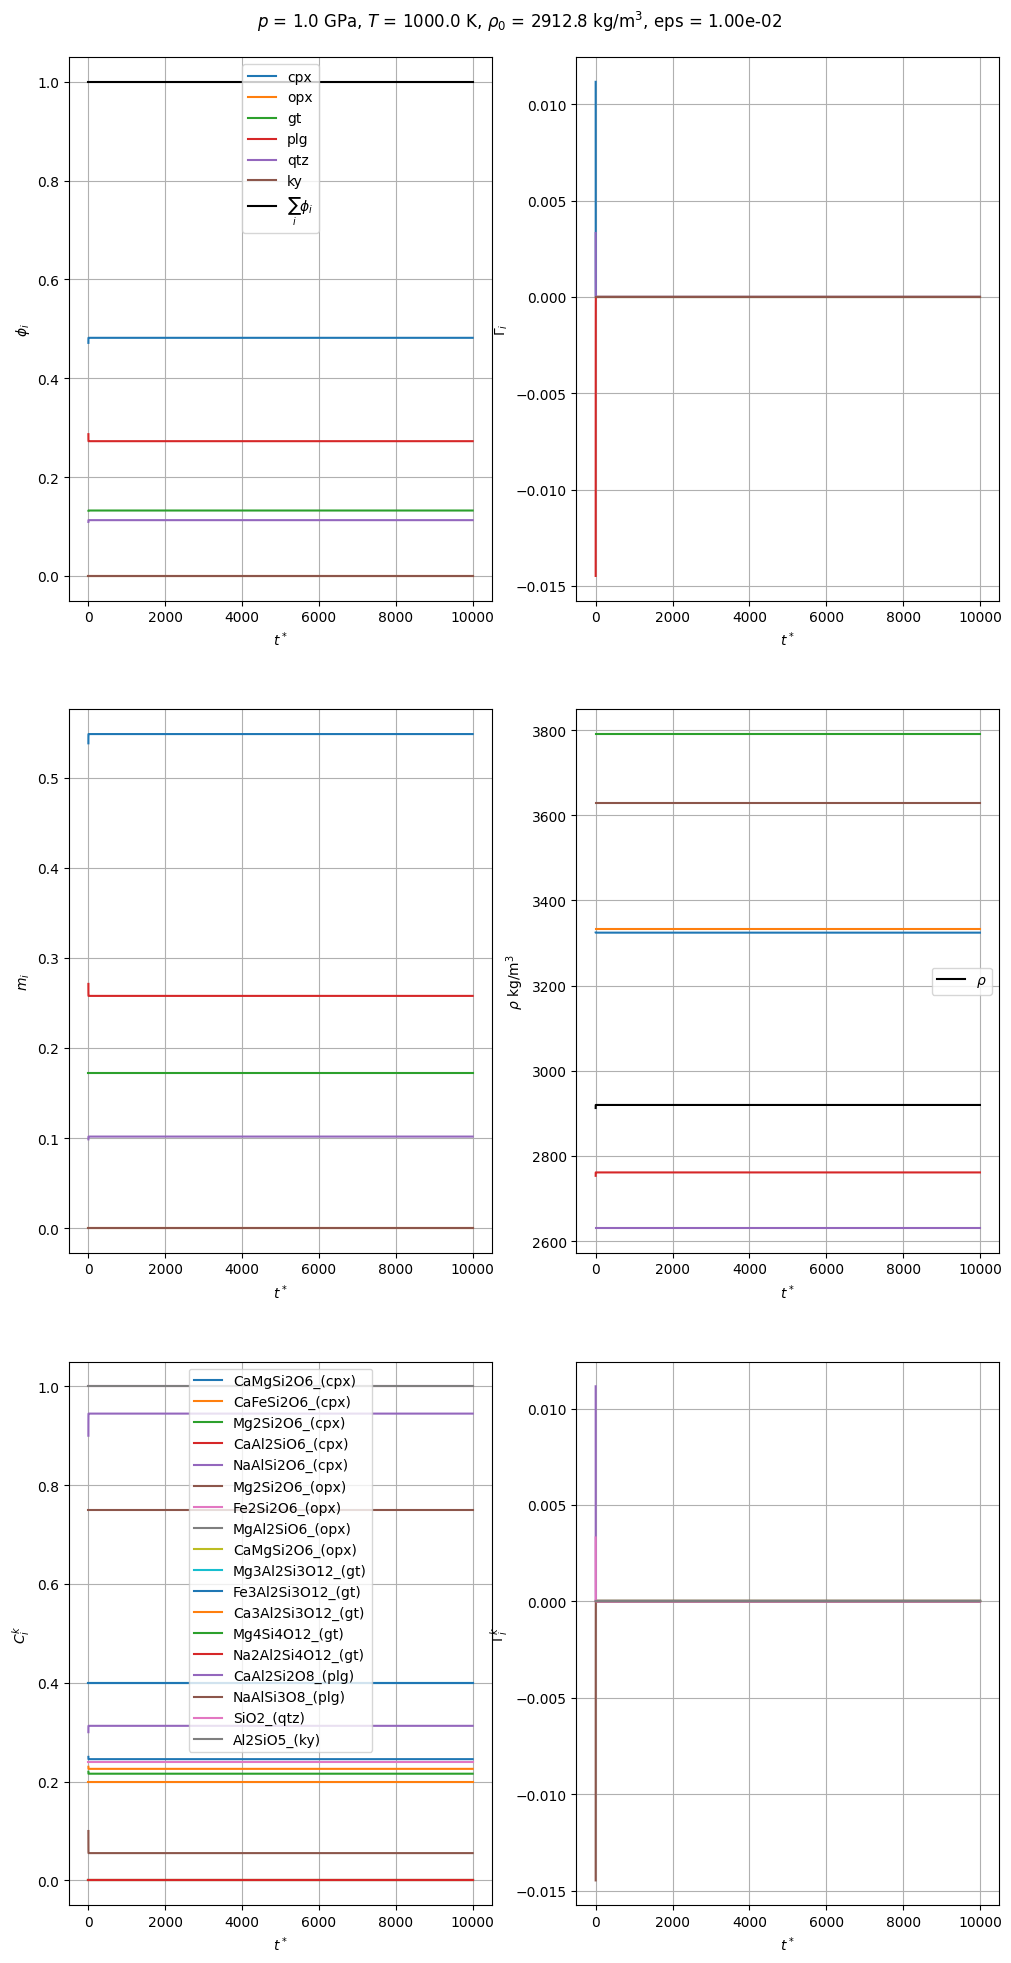

KeyboardInterrupt: 

In [9]:
run_reaction(
    "ec1_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=np.linspace(773.0, 1273.0, 5),
    p_range=np.linspace(0.5, 2.5, 5),
    reload=False,
    save=True
)

(array(['Clinopyroxene_slb_ph', 'Garnet_slb_ph', 'Feldspar_slb_ph',
        'Quartz_slb_ph'], dtype='<U20'),
 array(['cpx', 'gt', 'plg', 'qtz'], dtype='<U3'))

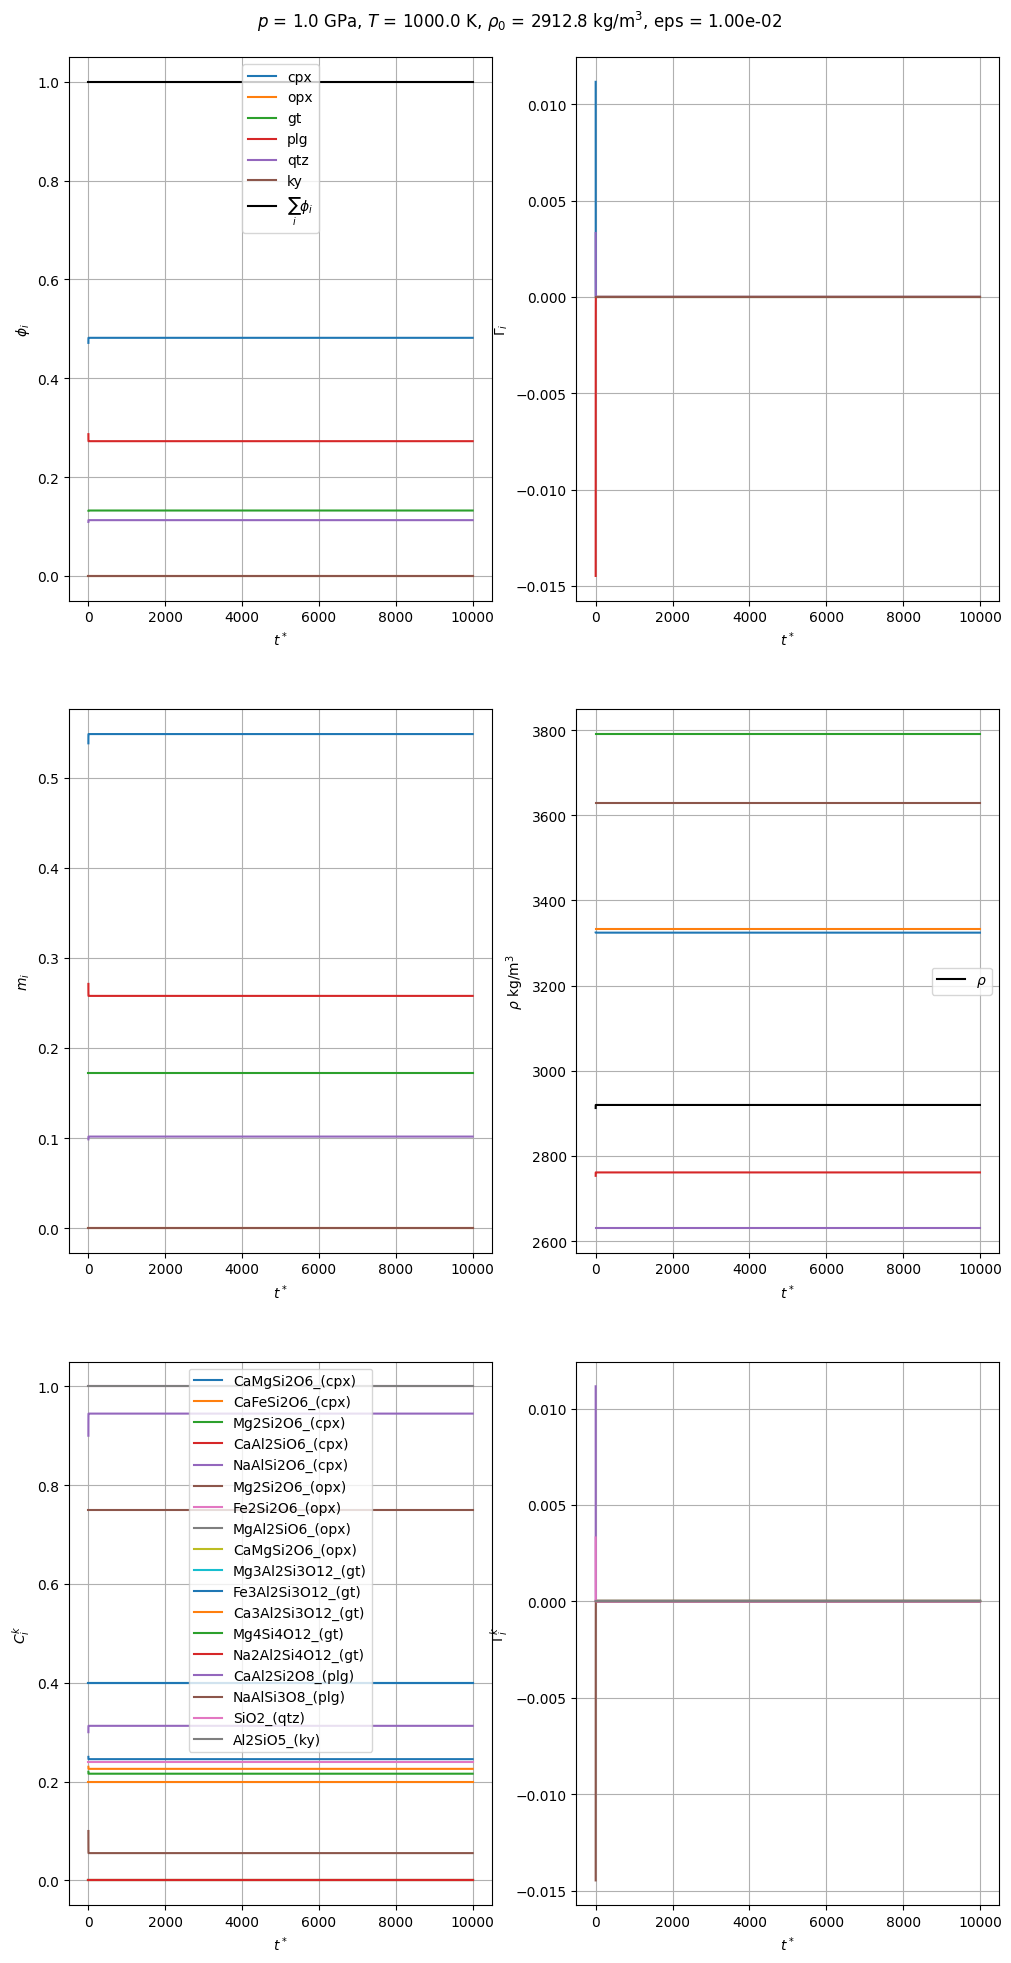

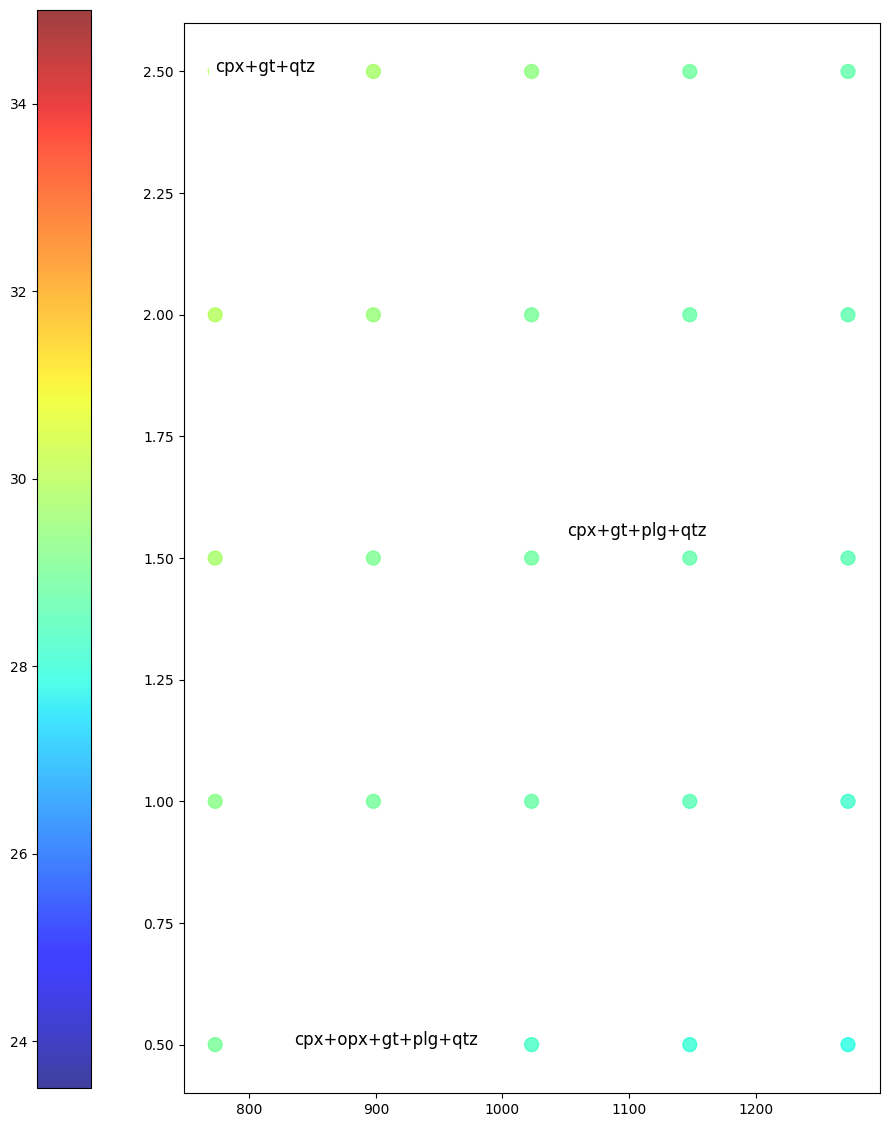

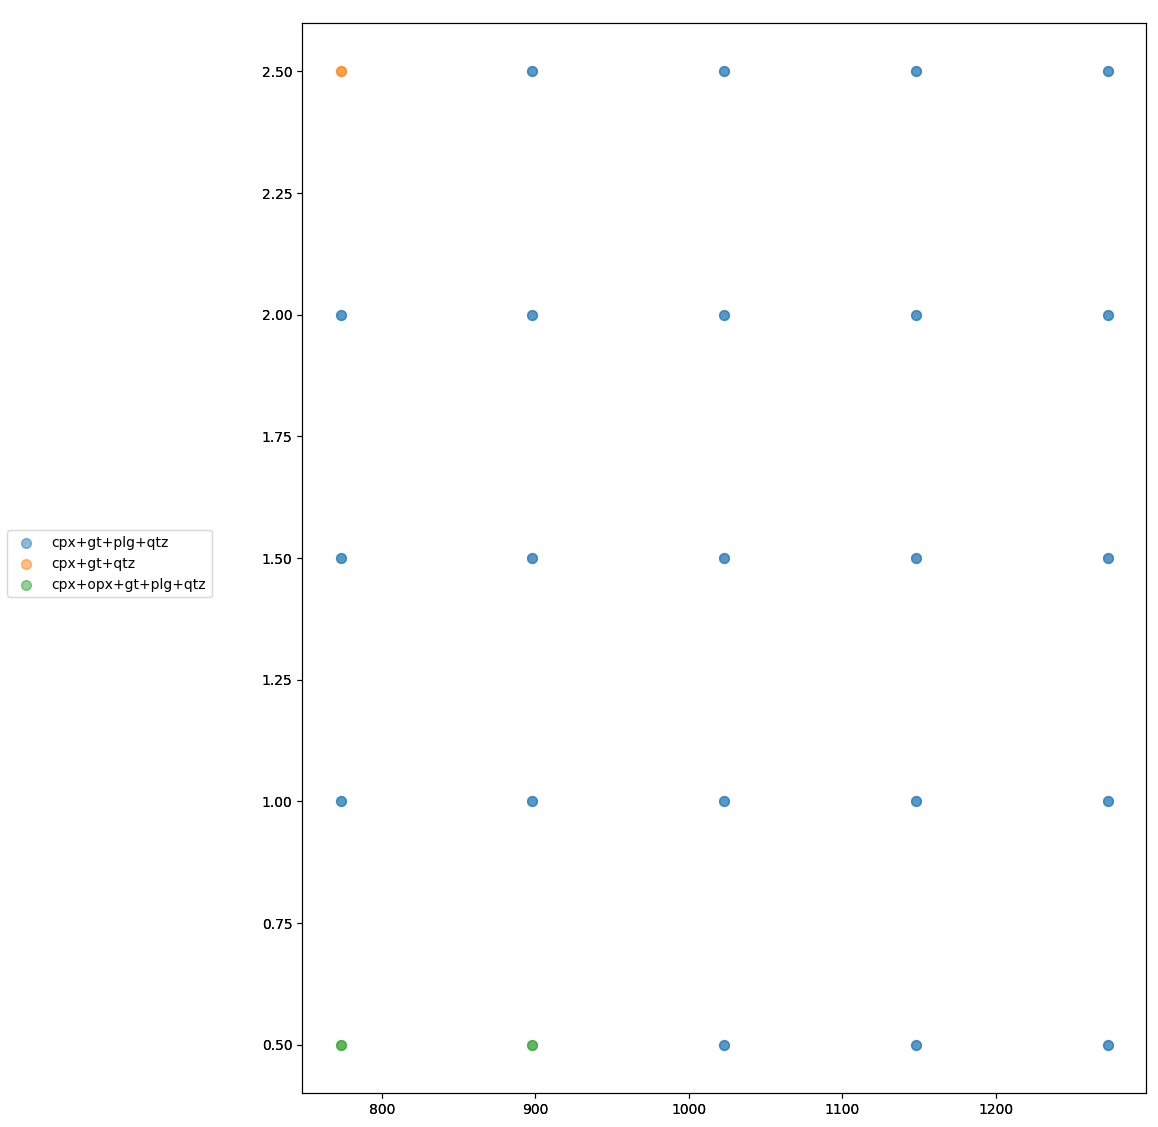

In [6]:
run_reaction(
    "ec2_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=np.linspace(773.0, 1273.0, 5),
    p_range=np.linspace(0.5, 2.5, 5),
    reload=False,
    save=False
)

In [6]:
run_reaction(
    "ec3_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    p_range=np.linspace(0.5, 2.5, 5),
    t_range=np.linspace(773.0, 1273.0, 5),
    reload=False,
    save=True
)

ImportError: dlopen(/Users/mmcmillan31/Documents/developer/tcg-ec/systems/ec/notebooks/../database/slb/install/ec3_slb_rx/lib/python3.9/site-packages/py_ec3_slb_rx.cpython-39-darwin.so, 0x0002): Library not loaded: '/Users/mmcmillan31/Documents/developer/tcg-ec/systems/ec/database/install/ec3_slb_rx/lib/libec3_slb_rx.dylib'
  Referenced from: '/Users/mmcmillan31/Documents/developer/tcg-ec/systems/ec/database/slb/install/ec3_slb_rx/lib/python3.9/site-packages/py_ec3_slb_rx.cpython-39-darwin.so'
  Reason: tried: '/Users/mmcmillan31/Documents/developer/tcg-ec/systems/ec/database/install/ec3_slb_rx/lib/libec3_slb_rx.dylib' (no such file), '/usr/local/lib/libec3_slb_rx.dylib' (no such file), '/usr/lib/libec3_slb_rx.dylib' (no such file)

(array(['Clinopyroxene_slb_ph', 'Garnet_slb_ph', 'Feldspar_slb_ph',
        'Quartz_slb_ph'], dtype='<U20'),
 array(['cpx', 'gt', 'plg', 'qtz'], dtype='<U3'))

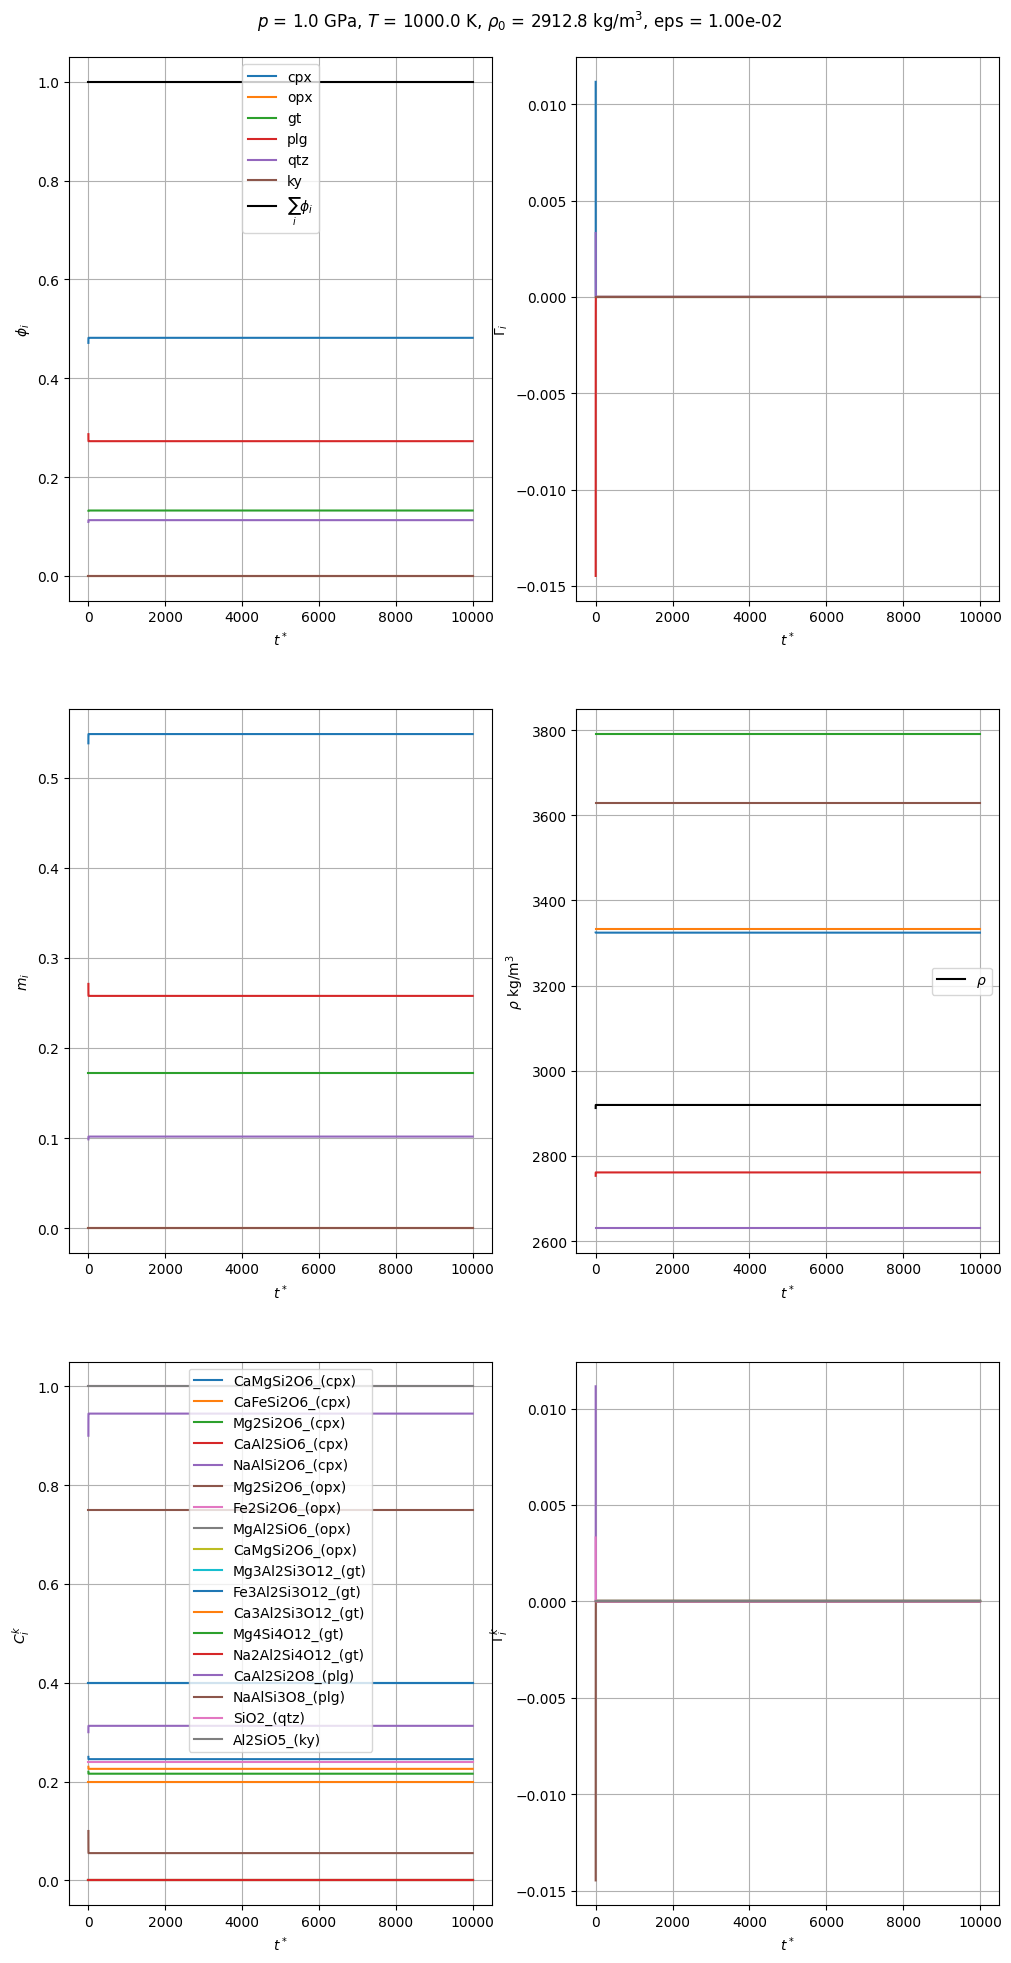

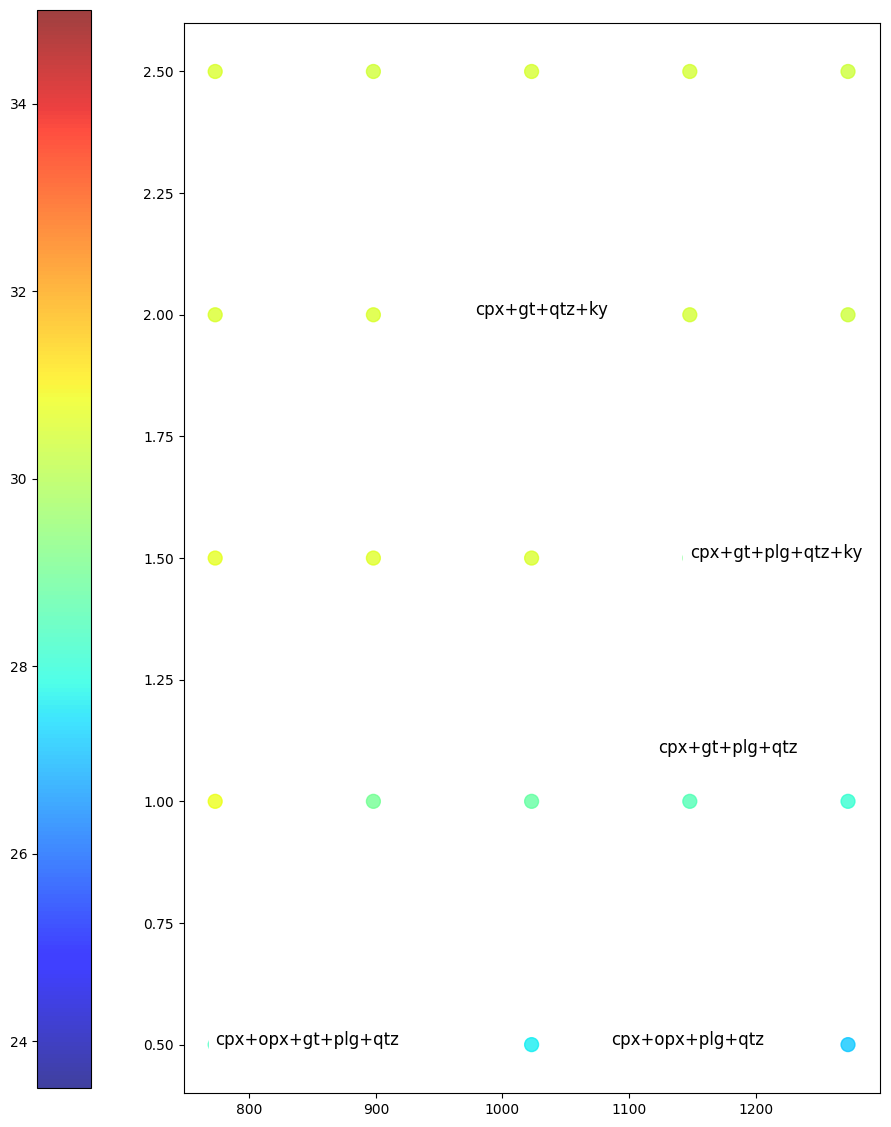

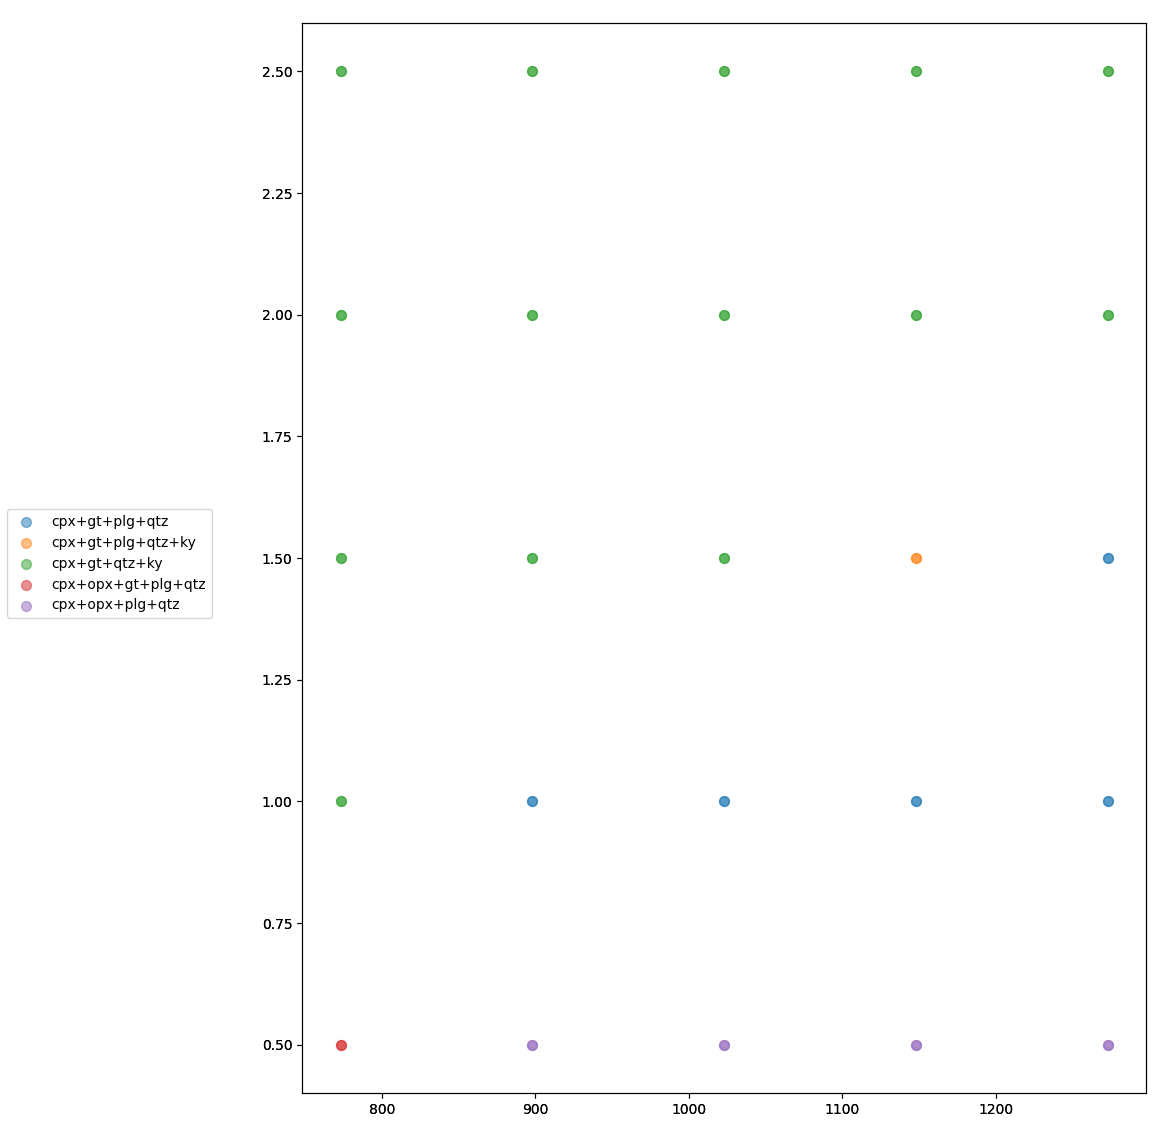

In [10]:
run_reaction(
    "ec4_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=np.linspace(773.0, 1273.0, 5),
    p_range=np.linspace(0.5, 2.5, 5),
    reload=False,
    save=True
)

In [6]:
run_reaction(
    "ec5_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=np.linspace(773.0, 1273.0, 20),
    p_range=np.linspace(0.5, 2.5, 20),
    reload=False,
    save=True
)
# 20x20 = ~40 mins

ModuleNotFoundError: No module named 'py_ec5_slb_rx'

In [3]:
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'tcg_ber_database',
                'lib', 'python3.9', 'site-packages'))  # the final slash is necessary!

import os
import sys
import py_tcg_ber_database as custom_db
import pickle
import json
import thermoengine as thermo
from thermoengine.equilibrate import PhaseLibrary
from tcg_slb.base import *
from tcg_slb.phasediagram.equilibrate import EquilibratePD, EquilibratePDGrid, PDEquilibrateGridDiagnostics
from thermoengine.const import units
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

with open("sammon.json") as json_file:
    comps = json.load(json_file)

comp = thermo.OxideWtComp(**comps["LC"])

db = thermo.model.Database.from_thermocodegen(custom_db)

phase_list = [
    "qtz",
    "gt",
    "cpx",
    "opx",
    "ky",
    "plg",
    "ru",
    "kfs",
    "hem",
    "sp"
]
phases = PhaseLibrary(db.get_phases(phase_list))

equil = EquilibratePD(phases)
equil.solve(1200, GPa2Bar(2.0), comp)

equil.assemblage.names, equil.assemblage.sample_amounts, equil.final_Ci0()


/Users/mmcmillan31/Library/Python/3.9/lib/python/site-packages/numdifftools/extrapolation.py:10: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d


Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code g

(array(['qtz', 'ky', 'ru', 'kfs', 'hem', 'gt', 'cpx', 'plg'], dtype='<U3'),
 array([0.11556566, 0.19347278, 0.00792637, 0.04162065, 0.05336816,
        0.01601859, 0.54823519, 0.03179462]),
 [('qtz', [1.0]),
  ('ky', [1.0]),
  ('ru', [1.0]),
  ('kfs', [1.0]),
  ('hem', [1.0]),
  ('gt', [1.0, 0.0, 0.0]),
  ('cpx', [0.7142623533234562, 0.0, 0.2857376466765438, 0.0]),
  ('plg', [0.2612592231313266, 0.7387407768686733])])

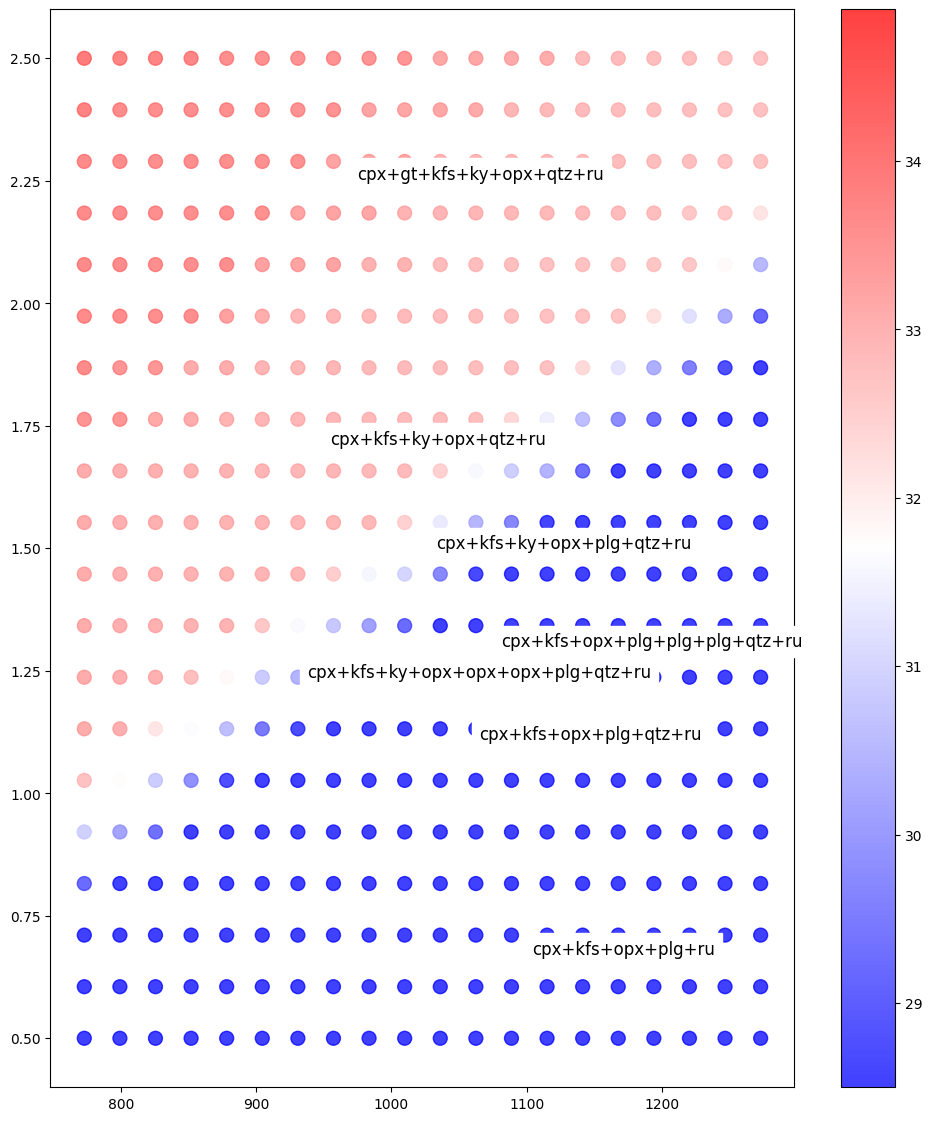

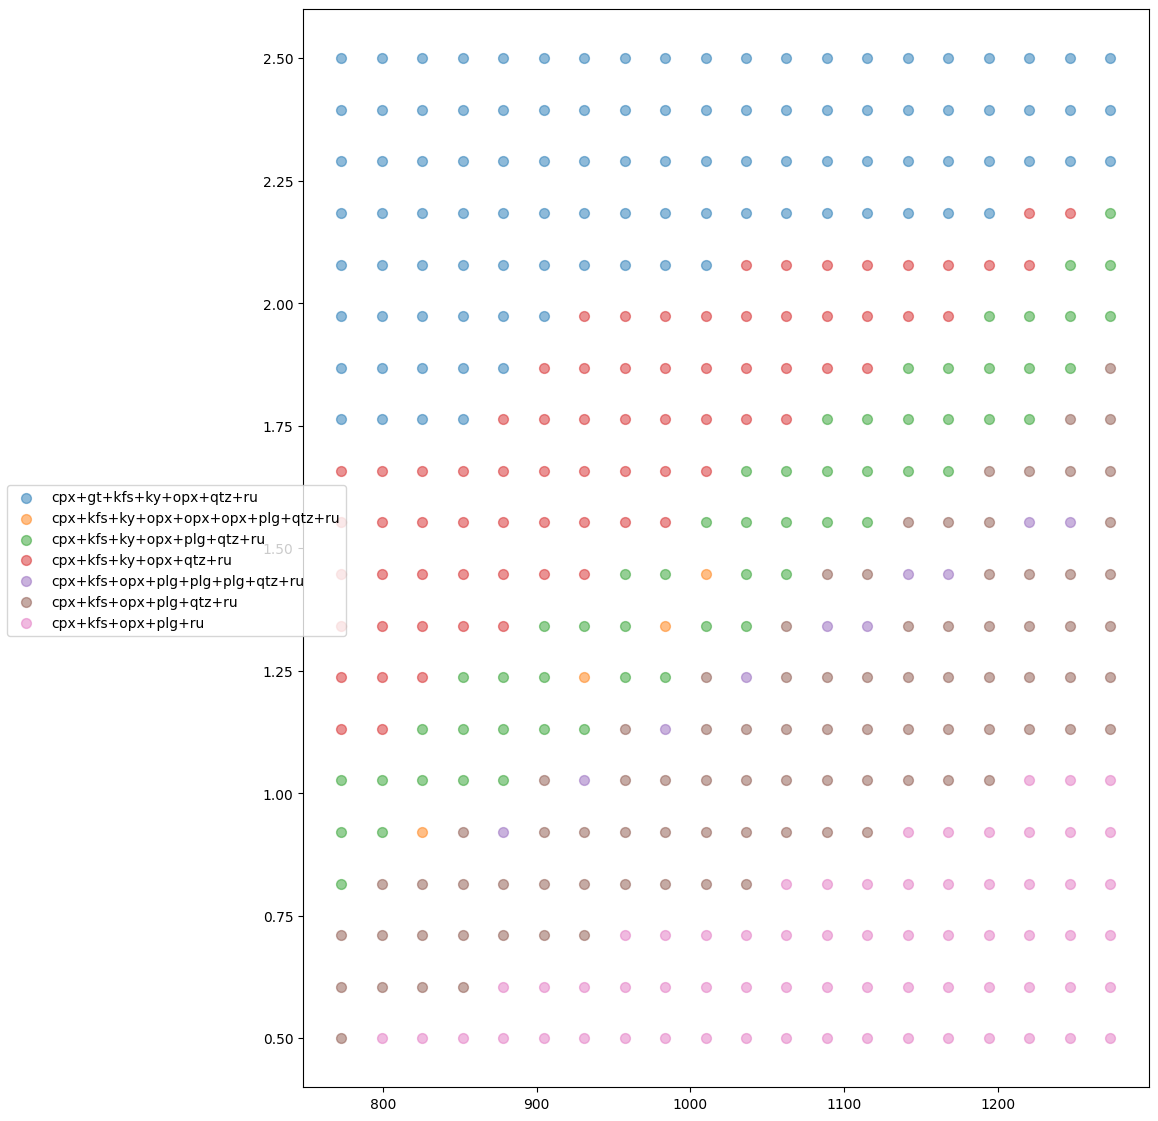

In [6]:

Tmin = 773
Tmax = 1273
nT = 20

Pmin = 0.5
Pmax = 2.5
nP = 20

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)

equilgrid = EquilibratePDGrid()
equilgrid.solve(phases, ['T', 'p'], T, P, **{'comp':comp})
equildiag = PDEquilibrateGridDiagnostics(phases, equilgrid)
equildiag.plot_rho()
equildiag.plot_phases()

(array(['Clinopyroxene_ber_ph', 'Orthopyroxene_ber_ph', 'Garnet_ber_ph',
        'Plagioclase_ber_ph', 'Quartz_ber_ph', 'Kyanite_ber_ph',
        'KFeldspar_ber_ph', 'Hematite_ber_ph'], dtype='<U20'),
 array(['cpx', 'opx', 'gt', 'plg', 'qtz', 'ky', 'kfs', 'hem'], dtype='<U3'))

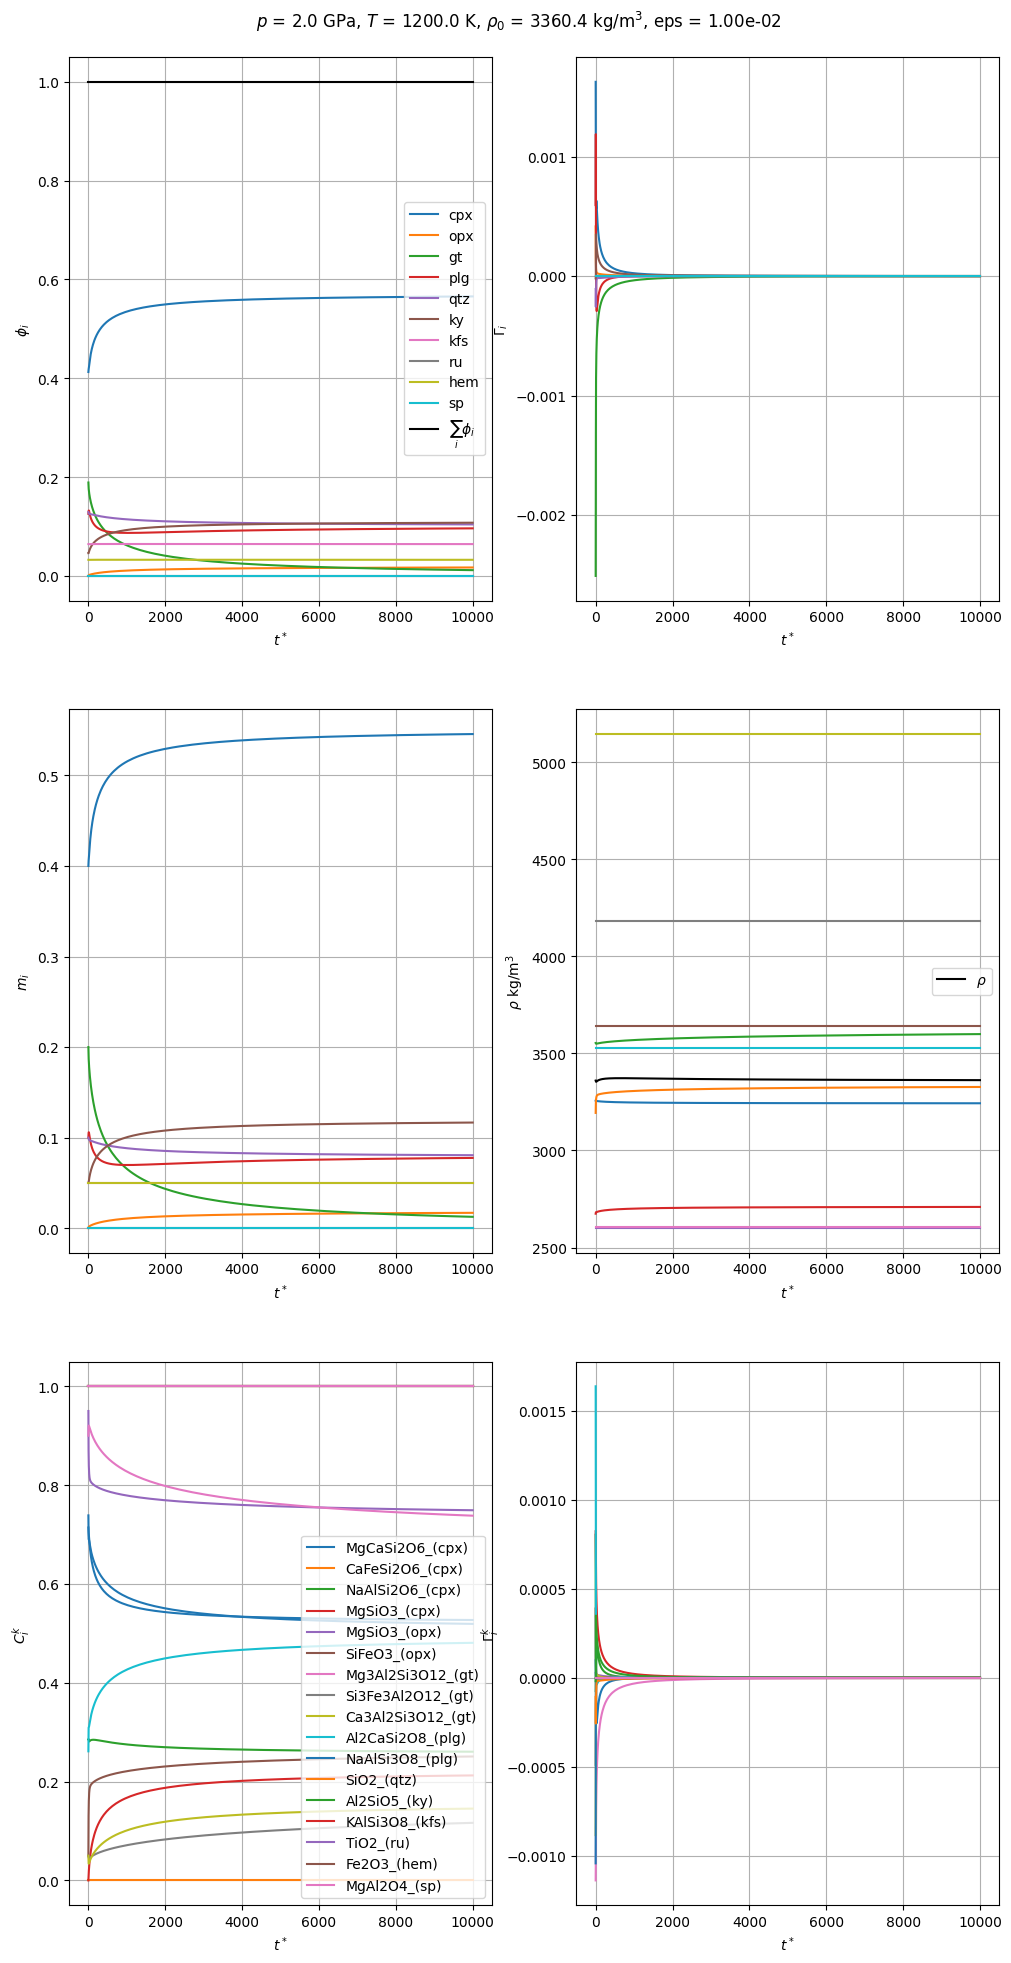

KeyboardInterrupt: 

In [8]:

Tmin = 773
Tmax = 1273
nT = 20

Pmin = 0.5
Pmax = 2.5
nP = 20

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)

mi0 = np.asarray([
    0.4,  # cpx
    0.0,  # opx
    0.2,  # gt
    0.1,  # plg
    0.1,  # qtz
    0.05,  # ky
    0.05,  # kfs
    0.0,  # ru
    0.05,  # hem
    0.000,  # sp
])

# initial compositions of phases in terms of EMs
Cik0 = np.asarray([            
    0.7142623533234562, 0.0, 0.2857376466765438, 0.0, # di, hed, jd, cEn
    0.95, 0.05,        # oEn, fsl
    0.9, 0.05, 0.05,   # py, al, gs
    0.2612592231313266, 0.7387407768686733,        # An, Ab
    1.,              # qtz
    1.,              # ky
    1.,              # ksp
    1.,              # ru
    1.,              # hematite
    1.,              # spinel
])
    
run_reaction(
    "ec5_ber_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=T,
    p_range=P,
    t0=1200,
    p0=2.0,
    reload=False,
    save=True,
)

(array(['Clinopyroxene_ber_ph', 'Garnet_ber_ph', 'Plagioclase_ber_ph',
        'Quartz_ber_ph', 'Kyanite_ber_ph', 'KFeldspar_ber_ph',
        'Hematite_ber_ph'], dtype='<U20'),
 array(['cpx', 'gt', 'plg', 'qtz', 'ky', 'kfs', 'hem'], dtype='<U3'))

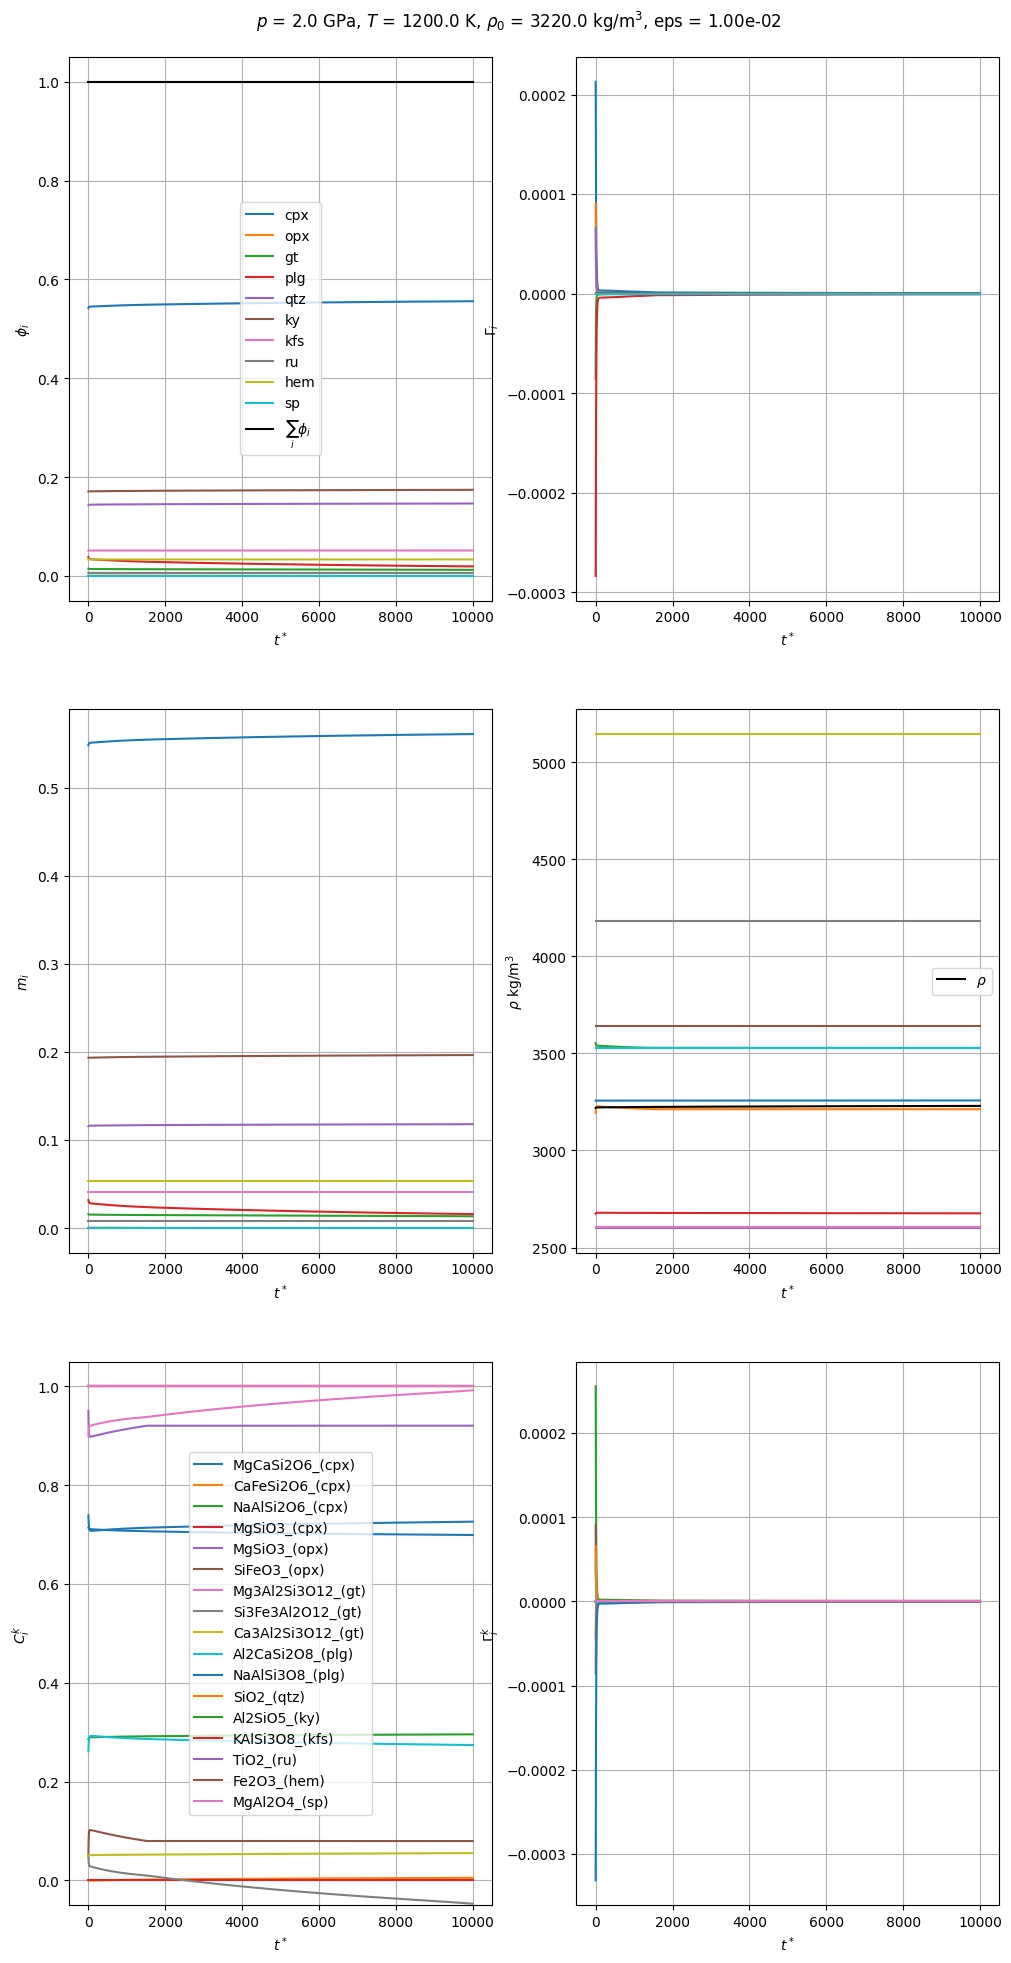

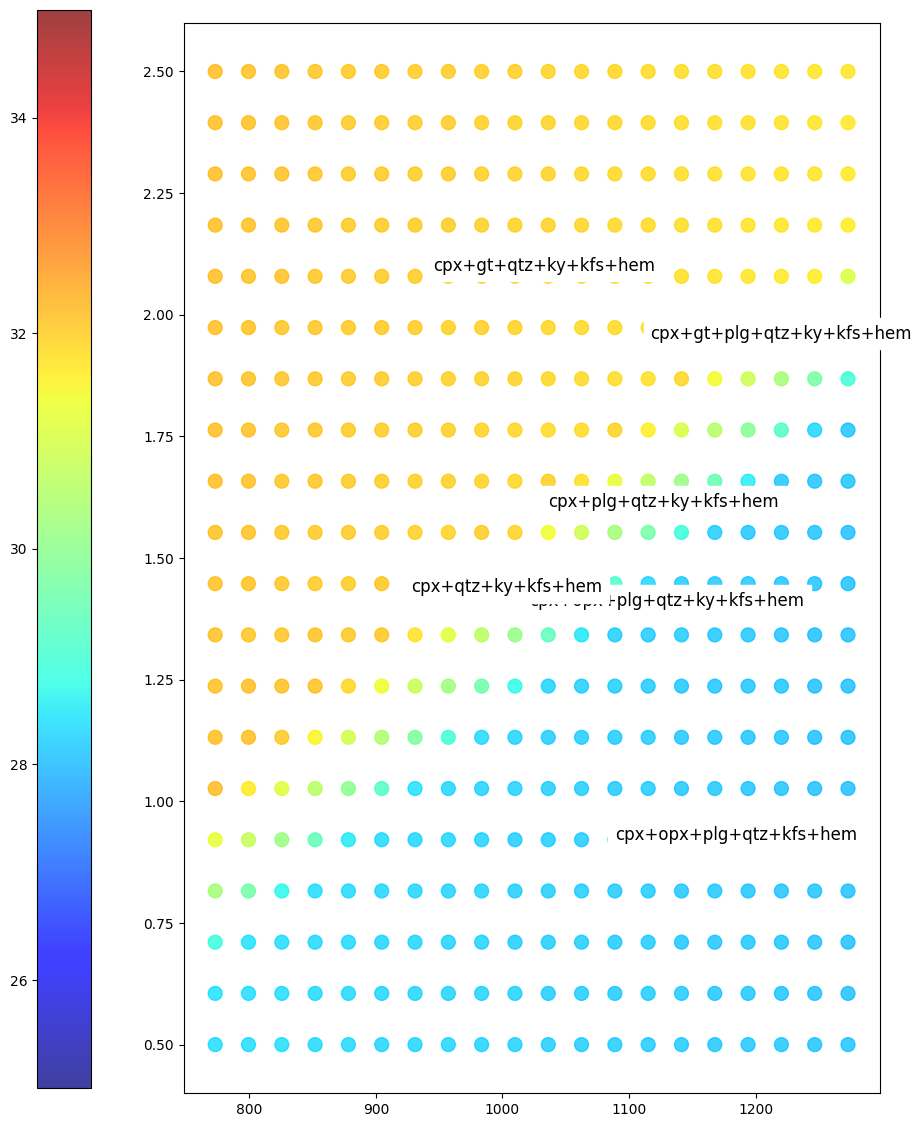

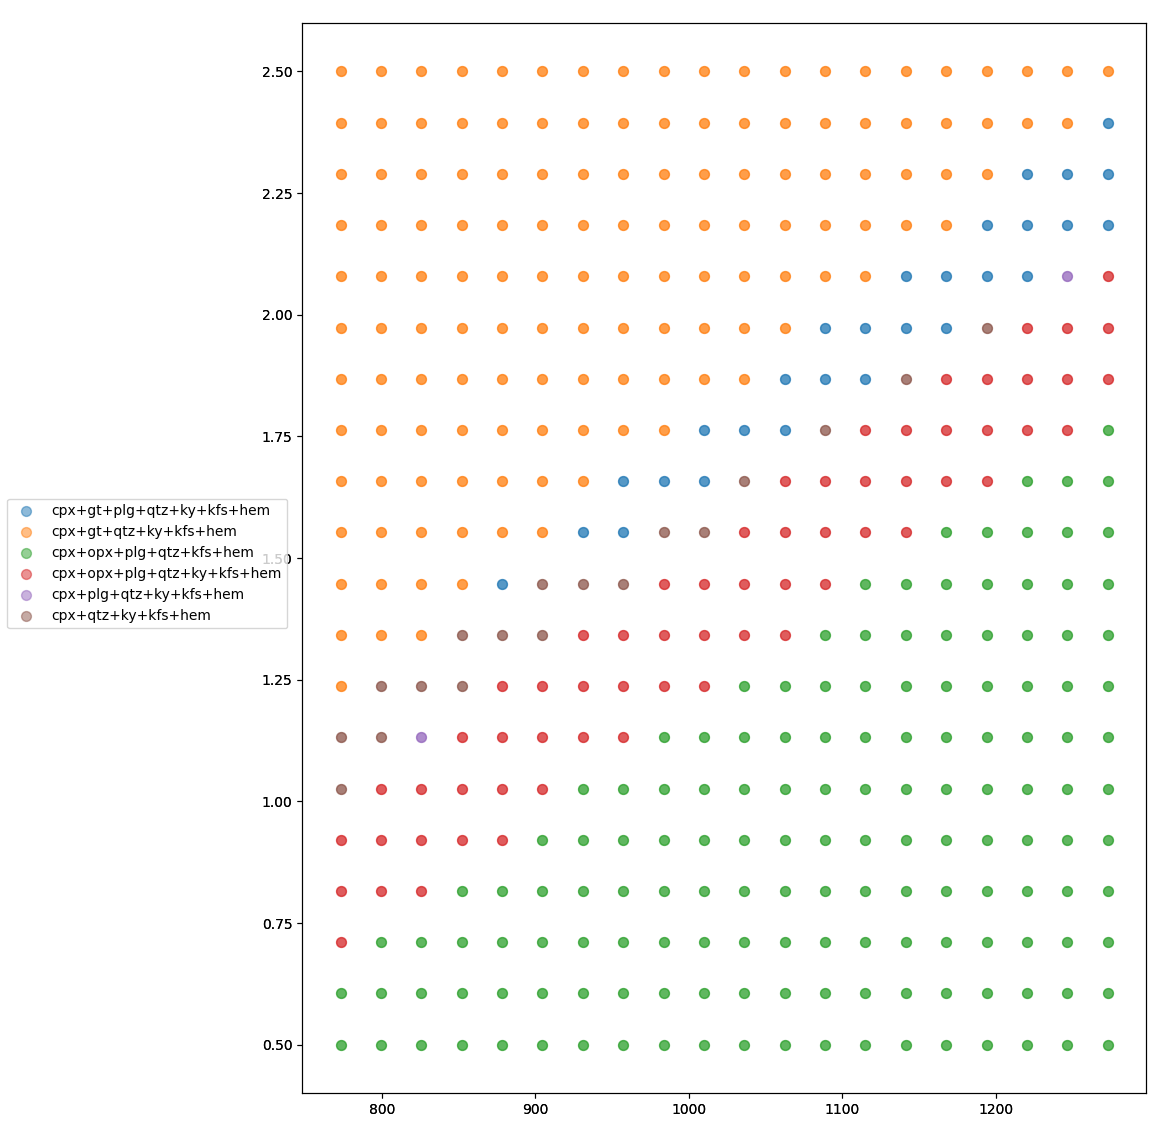

In [5]:
run_reaction(
    "ec7_ber_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=T,
    p_range=P,
    t0=1200,
    p0=2.0,
    reload=False,
    save=True,
)

(array(['Clinopyroxene_ber_ph', 'Orthopyroxene_ber_ph', 'Garnet_ber_ph',
        'Quartz_ber_ph', 'Kyanite_ber_ph', 'KFeldspar_ber_ph'],
       dtype='<U20'),
 array(['cpx', 'opx', 'gt', 'qtz', 'ky', 'kfs'], dtype='<U3'))

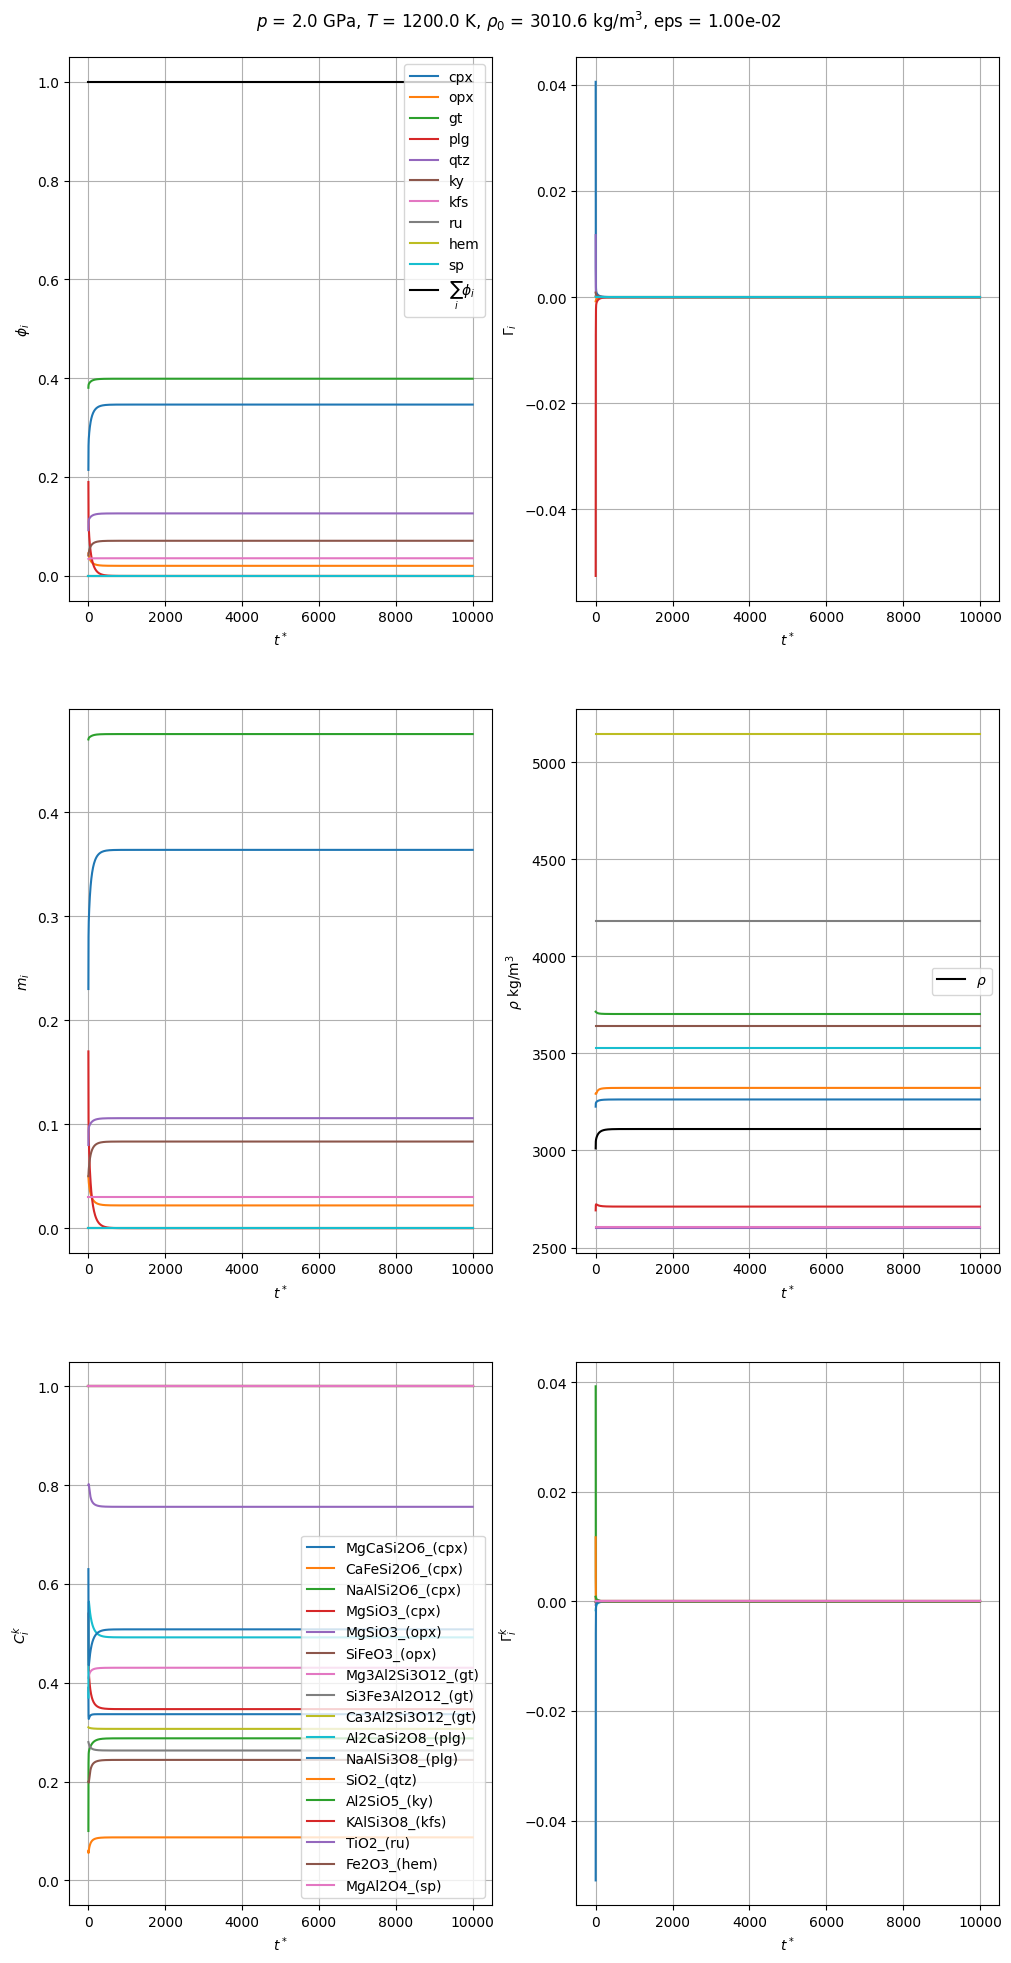

/Users/mmcmillan31/Library/Python/3.9/lib/python/site-packages/scipy/integrate/_ivp/bdf.py:407: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


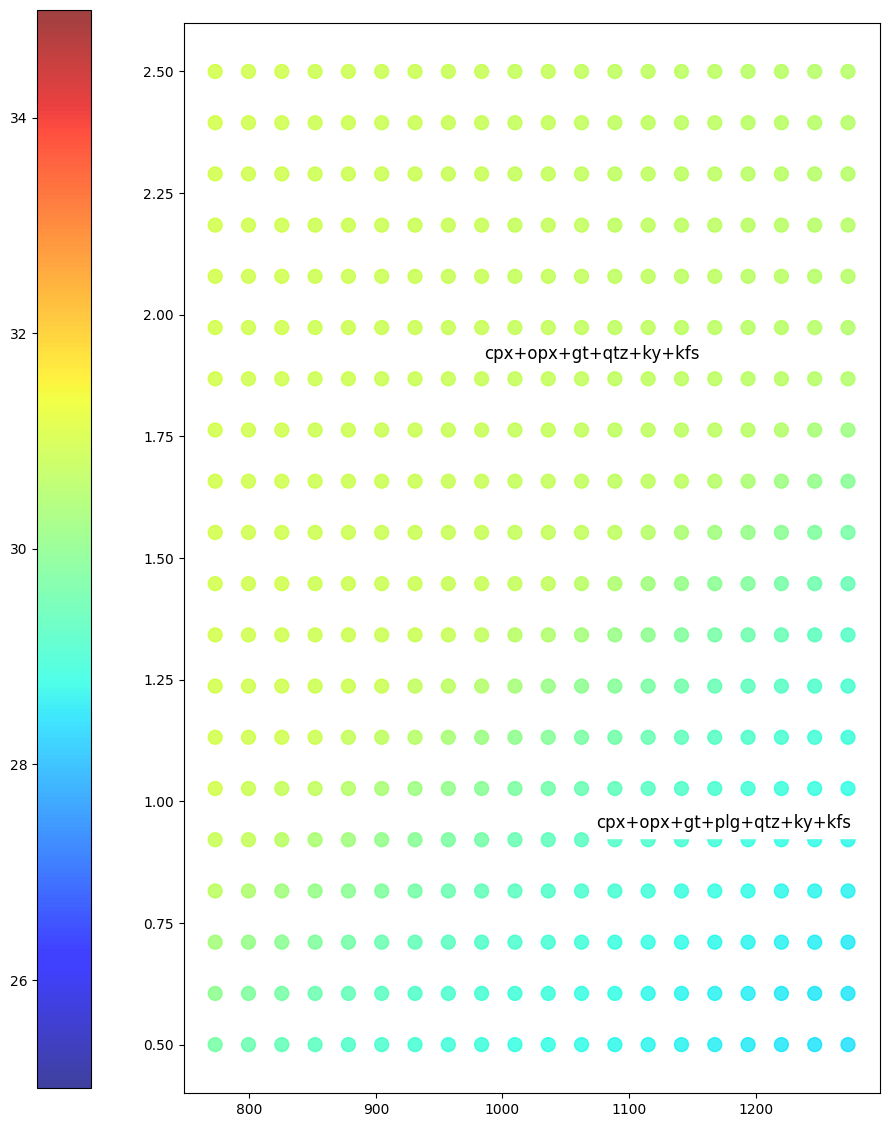

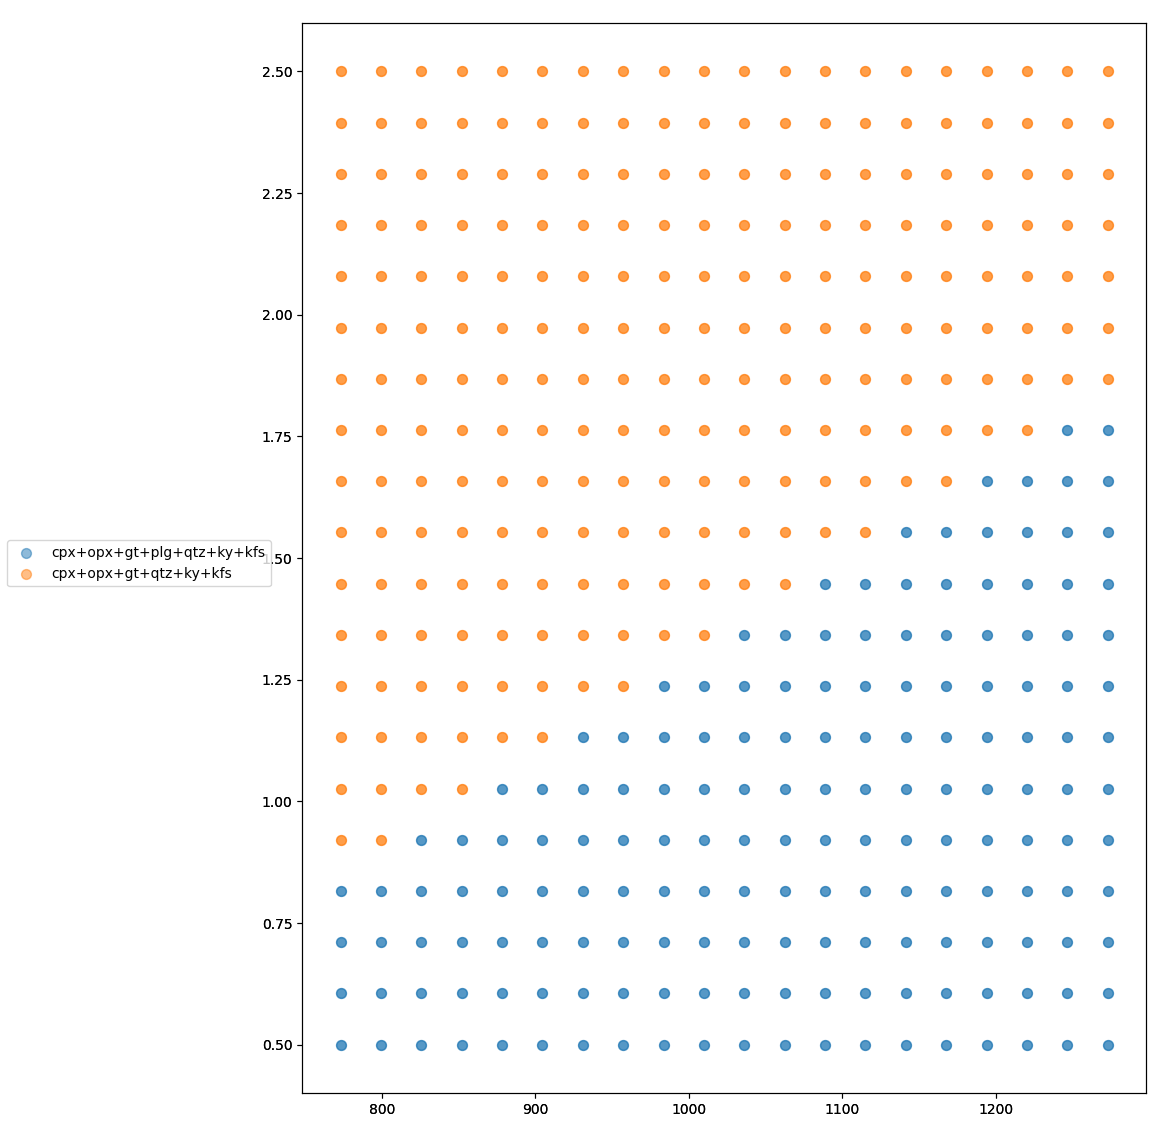

In [5]:
# Messing with initial composition

Tmin = 773
Tmax = 1273
nT = 20

Pmin = 0.5
Pmax = 2.5
nP = 20

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)

mi0 = np.asarray([
    0.23,  # cpx
    0.05,  # opx
    0.47,  # gt
    0.17,  # plg
    0.08,  # qtz
    0.05,  # ky
    0.03,  # kfs
    0.00,  # ru
    0.00,  # hem
    0.00,  # sp
])

# initial compositions of phases in terms of EMs
Cik0 = np.asarray([            
    0.39, 0.06, 0.1, 0.54, # di, hed, jd, cEn
    0.8, 0.2,        # oEn, fsl
    0.41, 0.28, 0.31,   # py, al, gs
    0.37, 0.63,        # An, Ab
    1.,              # qtz
    1.,              # ky
    1.,              # ksp
    1.,              # ru
    1.,              # hematite
    1.,              # spinel
])
    
run_reaction(
    "ec7_ber_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=T,
    p_range=P,
    t0=1200,
    p0=2.0,
    reload=False,
    save=True,
)

In [3]:
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'tcg_hgp_database',
                'lib', 'python3.9', 'site-packages'))  # the final slash is necessary!
sys.path.append(os.path.join(os.path.pardir, 'python'))  # the final slash is necessary!
import os
import sys
import py_tcg_hgp_database as hgp_db
import pickle
import json
import thermoengine as thermo
from thermoengine.equilibrate import PhaseLibrary
from tcg_slb.base import *
from tcg_slb.phasediagram.equilibrate import EquilibratePD, EquilibratePDGrid, PDEquilibrateGridDiagnostics
from thermoengine.const import units
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

with open("sammon.json") as json_file:
    comps = json.load(json_file)

comp = thermo.OxideWtComp(**comps["LC"])

db = thermo.model.Database.from_thermocodegen(hgp_db)

phases = PhaseLibrary(db.get_phases([
    'q','ru','ky','mic',
    'cpx','opx','plg','gt'
]))

phases = PhaseLibrary(db.get_all_phases())

equil = EquilibratePD(phases)
equil.solve(1200, GPa2Bar(2.0), comp)

equil.assemblage.names, equil.assemblage.sample_amounts, equil.final_Ci0()


/Users/mmcmillan31/Library/Python/3.9/lib/python/site-packages/numdifftools/extrapolation.py:10: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d


Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code g

(array(['sph', 'q', 'mic', 'ky', 'bix', 'Ilm', 'gt', 'cpx'], dtype='<U3'),
 array([0.02113698, 0.10519642, 0.04162065, 0.2406901 , 0.00121465,
        0.02517699, 0.02296867, 0.55121235]),
 [('sph', [1.0]),
  ('q', [1.0]),
  ('mic', [1.0]),
  ('ky', [1.0]),
  ('bix', [1.0]),
  ('Ilm', [0.0, 1.0]),
  ('gt',
   [0.04200660074254706, 0.0, 0.3755036094088195, 0.5824897898486334, 0.0]),
  ('cpx',
   [0.601708504791104,
    0.0,
    0.14041472289674767,
    0.06354443726552705,
    0.19433233504662126])])

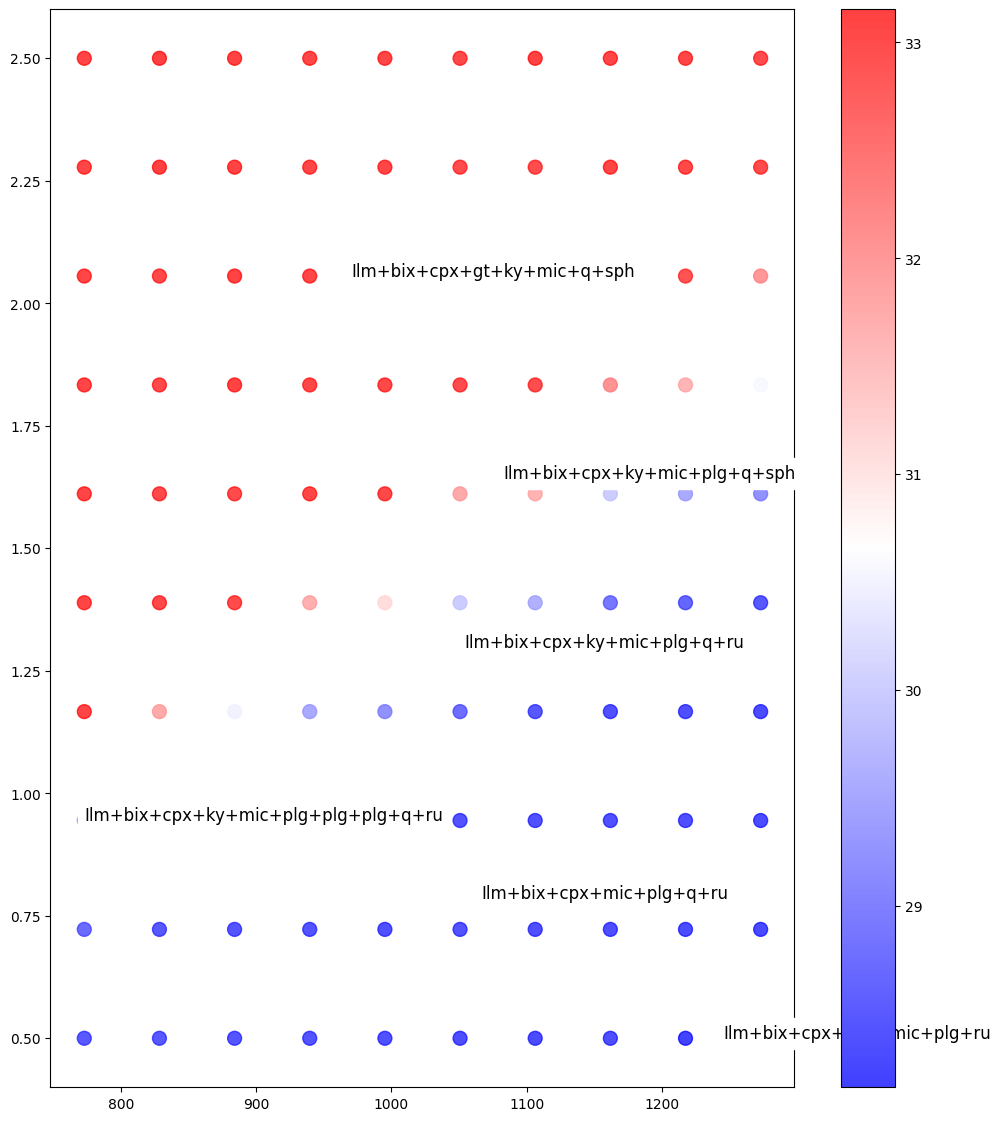

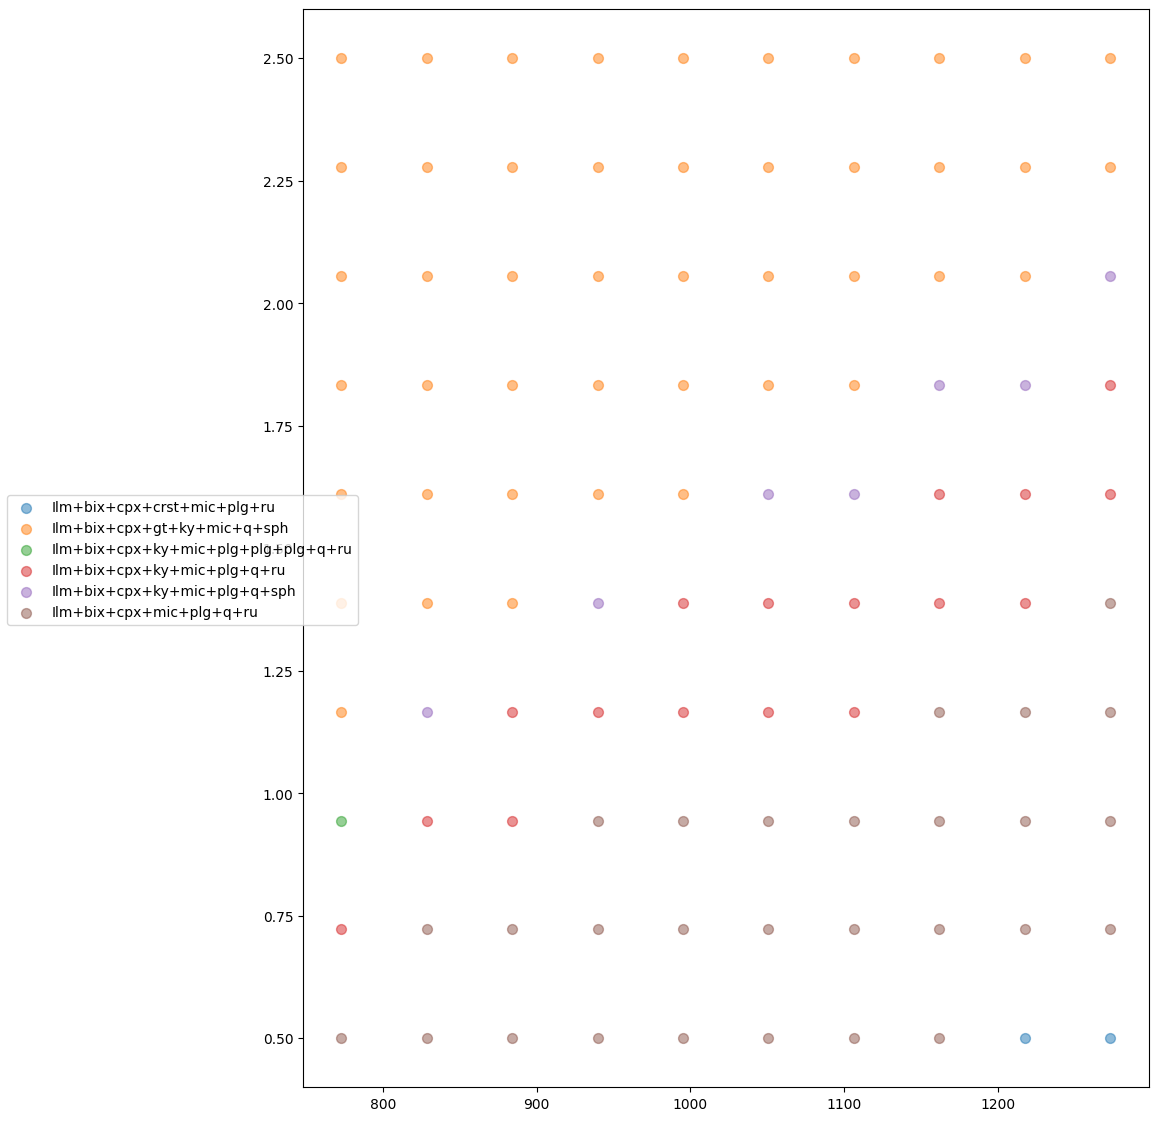

In [4]:
Tmin = 773
Tmax = 1273
nT = 10

Pmin = 0.5
Pmax = 2.5
nP = 10

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)

equilgrid = EquilibratePDGrid()
equilgrid.solve(phases, ['T', 'p'], T, P, **{'comp':comp})
equildiag = PDEquilibrateGridDiagnostics(phases, equilgrid)
equildiag.plot_rho()
equildiag.plot_phases()

In [58]:
sys.path.append(os.path.join(os.path.pardir, 'database', 'install', 'tcg_hgp_database',
                'lib', 'python3.9', 'site-packages'))  # the final slash is necessary!
sys.path.append(os.path.join(os.path.pardir, 'python'))  # the final slash is necessary!
import os
import sys
import py_tcg_hgp_database as hgp_db
import pickle
import json
import thermoengine as thermo
from thermoengine.equilibrate import PhaseLibrary
from tcg_slb.base import *
from tcg_slb.phasediagram.equilibrate import EquilibratePD, EquilibratePDGrid, PDEquilibrateGridDiagnostics
from thermoengine.const import units
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)

with open("sammon.json") as json_file:
    comps = json.load(json_file)

systems = {
    "NFAS": ["Na2O","FeO","Al2O3","SiO2"],
    "NFMAS": ["Na2O","FeO","MgO","Al2O3","SiO2"],
    "NCFMAS": ["Na2O","CaO","FeO","MgO","Al2O3","SiO2"],
    "KFMAS": ['K2O','FeO','MgO','Al2O3','SiO2']
}

comp = comps['LC']

for system in systems:
    comps[system] = dict((key, comp[key]) for key in comp if key in systems[system])


wtcomp = thermo.OxideWtComp(**comps['LC']).normalize()
print(wtcomp)
db = thermo.model.Database.from_thermocodegen(hgp_db)

phase_list = db.get_phases([
    'cpx',#'jd','di','cen',
    'en','fs',
    'ky',
    'fspr',
    'q',
    'ru',
    'alm','spss','nagt',
    'ab','an'])

phases = PhaseLibrary(phase_list)

equil = EquilibratePD(phases)
equil.solve(1000, GPa2Bar(0.02), wtcomp)

equil.assemblage.names, equil.assemblage.sample_amounts, equil.final_Ci0()

OxideWtComp(SiO2=0.5328401479556134, TiO2=0.009797060881735481, Al2O3=0.1719484154753574, Fe2O3=0.0, Cr2O3=0.0, FeO=0.07117864640607818, MnO=0.0015995201439568132, MgO=0.07627711686494053, NiO=0.0, CoO=0.0, CaO=0.10146955913226034, Na2O=0.026292112366290116, K2O=0.006997900629811057, P2O5=0.0015995201439568132, H2O=0.0, CO2=0.0)
Solution phase code generated by the coder module does not yet provide information on solution species. Species are proxied by components.
Solution phase code generated by the coder module does not yet provide information on species properties. Species are proxied by components.


(array(['ky', 'q', 'ru', 'alm', 'spss', 'an', 'cpx'], dtype='<U4'),
 array([0.00834839, 0.10606185, 0.00792637, 0.00650377, 0.00323907,
        0.45249432, 0.41806486]),
 [('ky', [1.0]),
  ('q', [1.0]),
  ('ru', [1.0]),
  ('alm', [1.0]),
  ('spss', [1.0]),
  ('an', [1.0]),
  ('cpx',
   [0.04986246126698652,
    0.057125191919167186,
    0.0,
    0.42782739215480653,
    0.4651849546590398])])

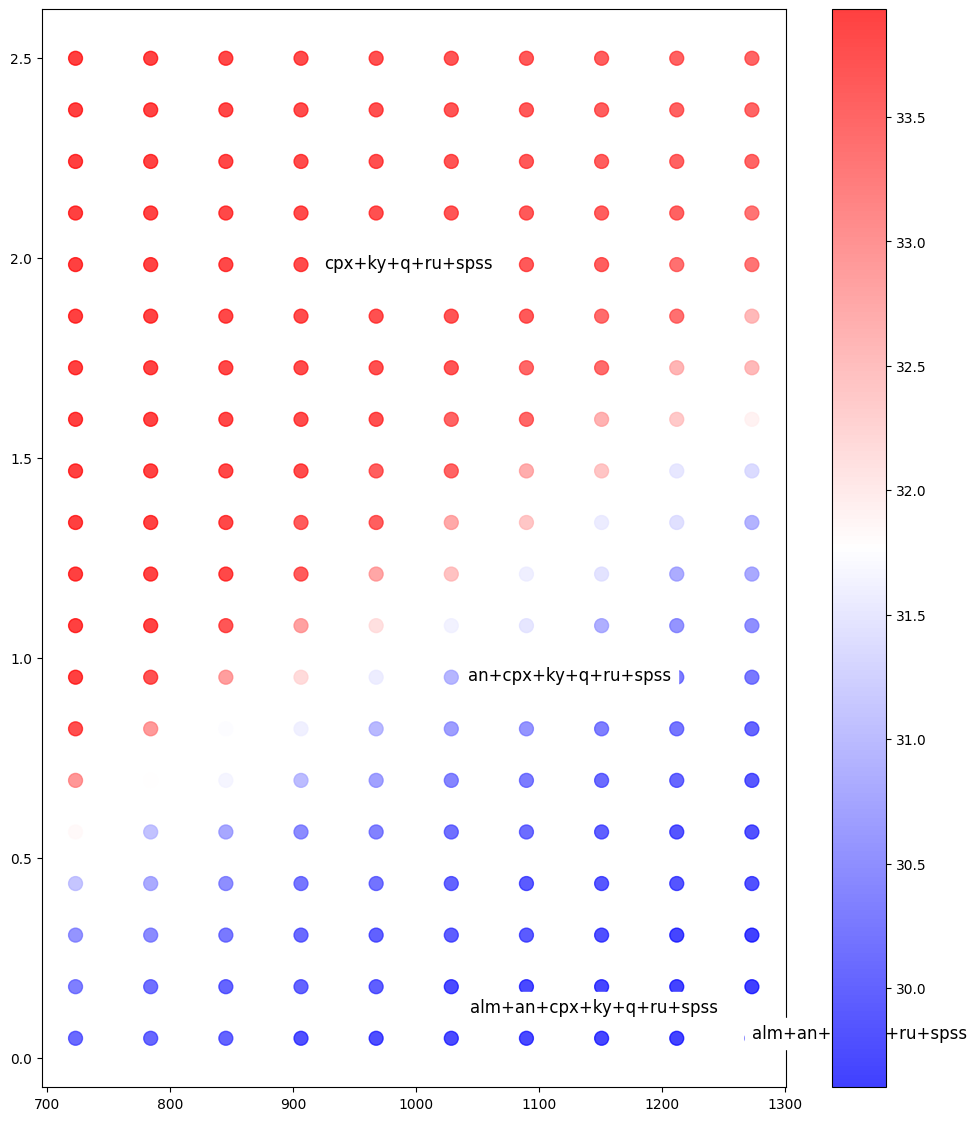

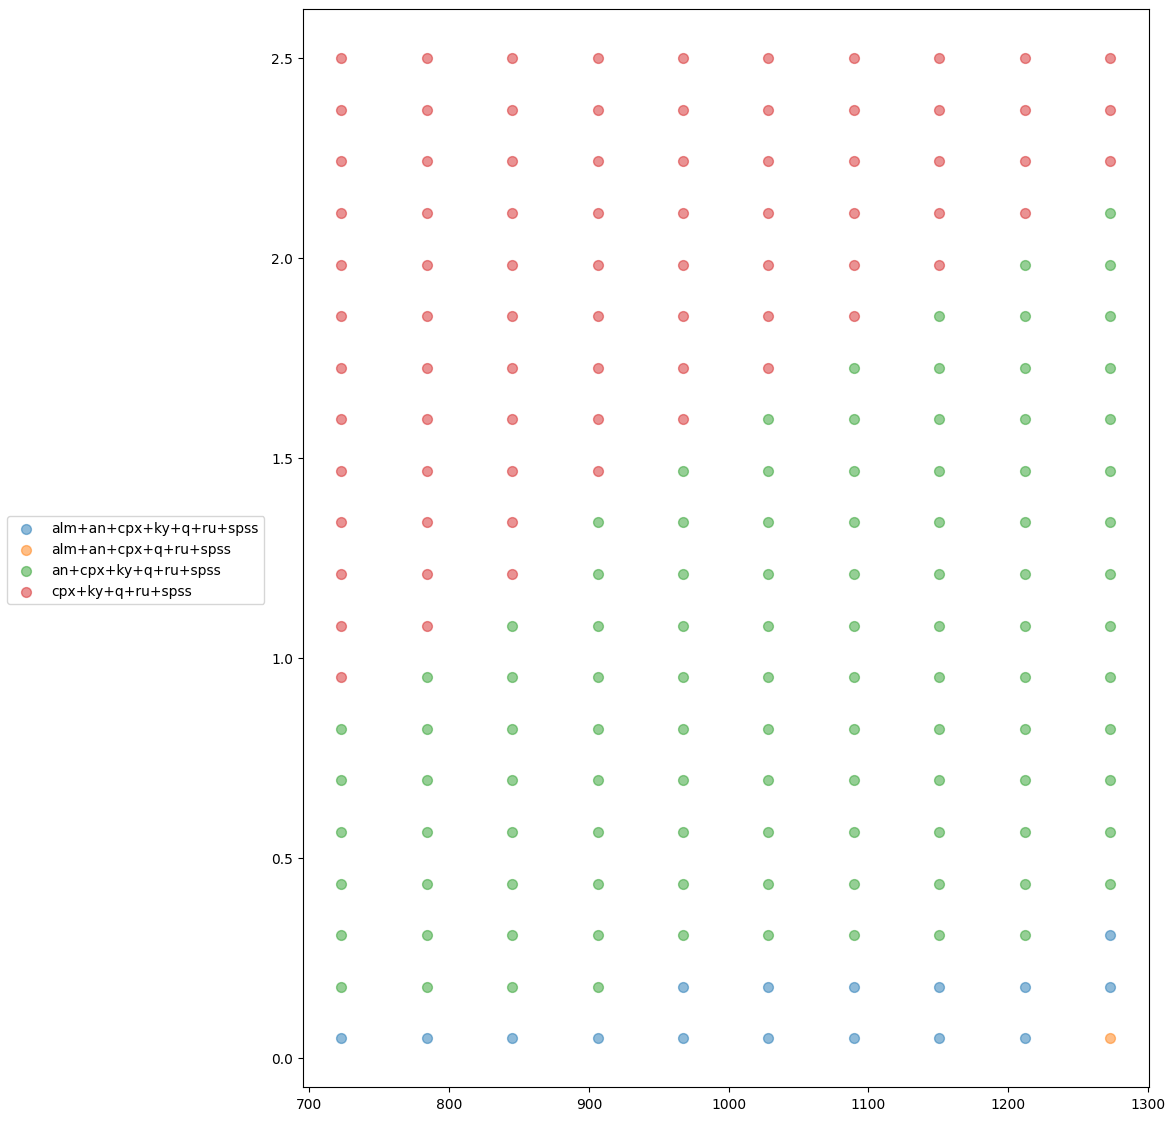

In [59]:
Tmin = 723
Tmax = 1273
nT = 10

Pmin = 0.05
Pmax = 2.5
nP = 20

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)

equilgrid = EquilibratePDGrid()
equilgrid.solve(phases, ['T', 'p'], T, P, **{'comp':wtcomp})
equildiag = PDEquilibrateGridDiagnostics(phases, equilgrid)
equildiag.plot_rho()
equildiag.plot_phases()

(array(['di_hgp_ph', 'hed_hgp_ph', 'q_hgp_ph', 'ab_hgp_ph', 'an_hgp_ph',
        'py_hgp_ph', 'gr_hgp_ph', 'alm_hgp_ph', 'ky_hgp_ph'], dtype='<U11'),
 array(['di', 'hed', 'q', 'ab', 'an', 'py', 'gr', 'alm', 'ky'], dtype='<U4'))

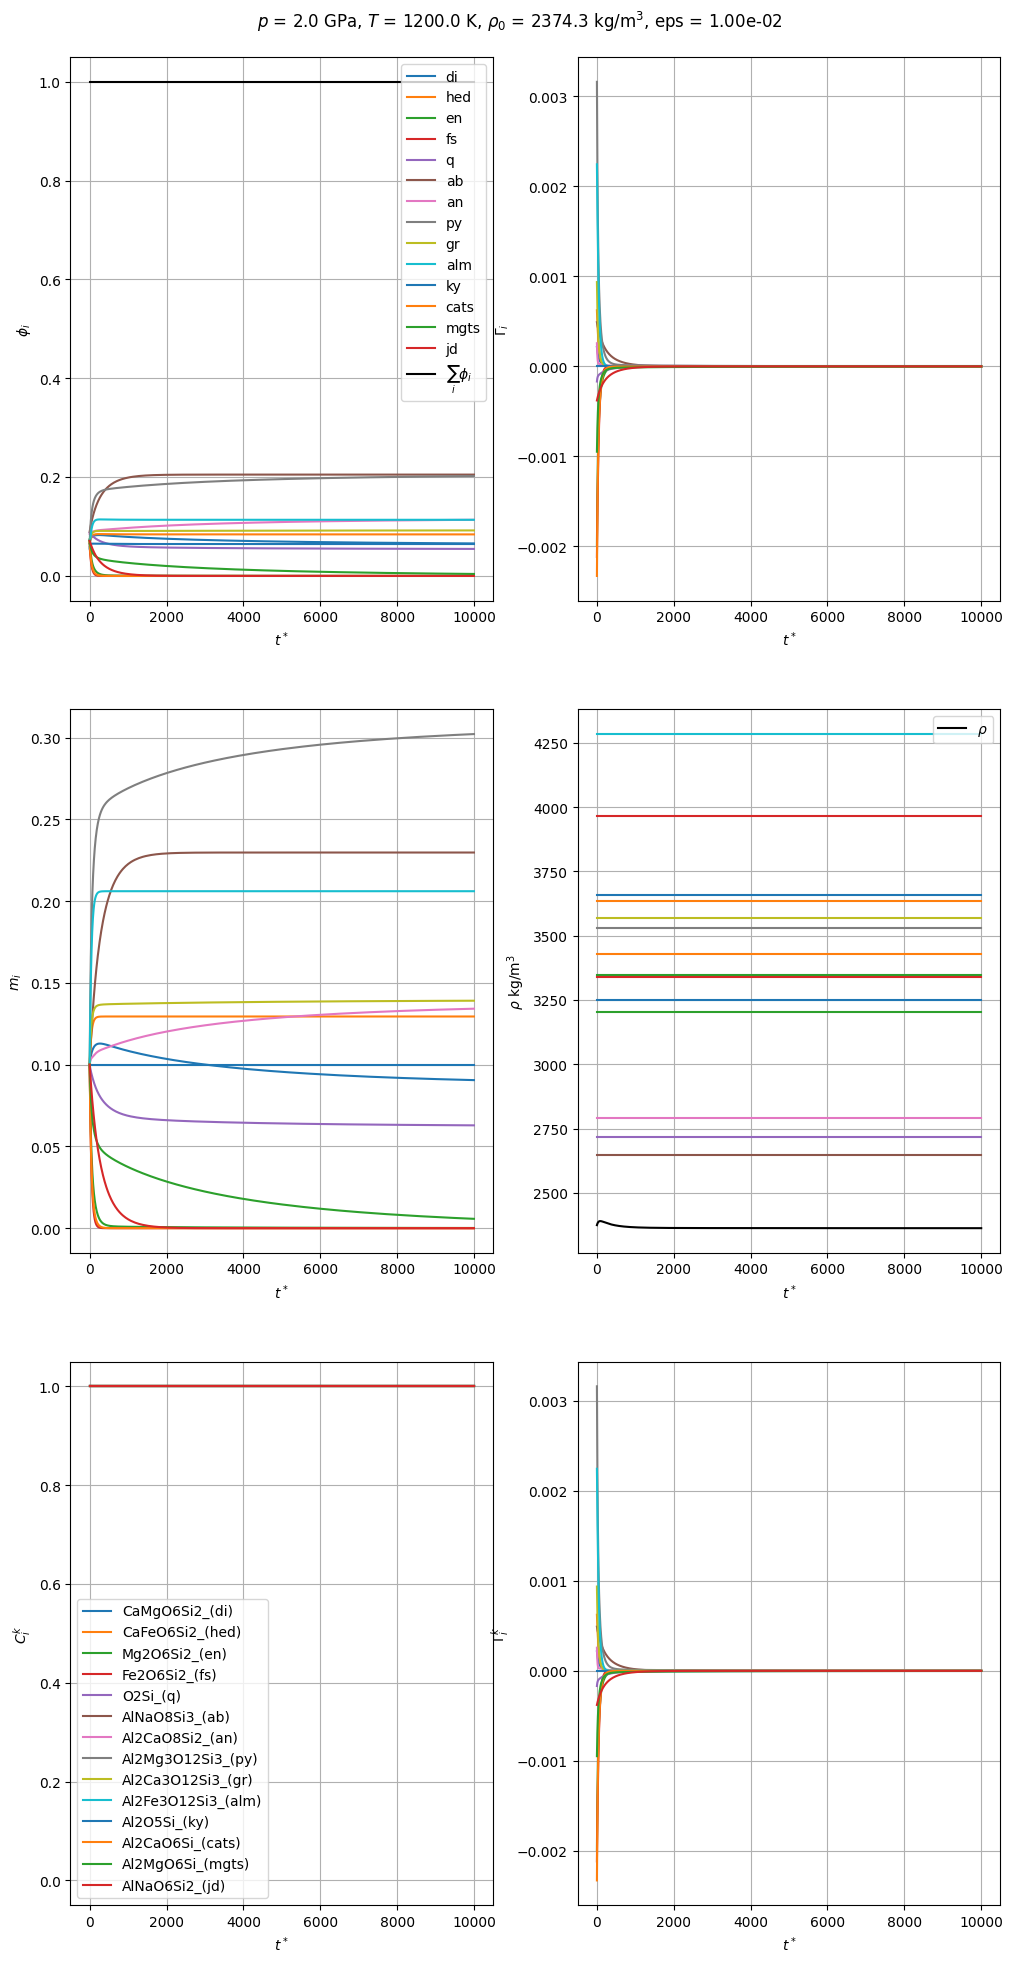

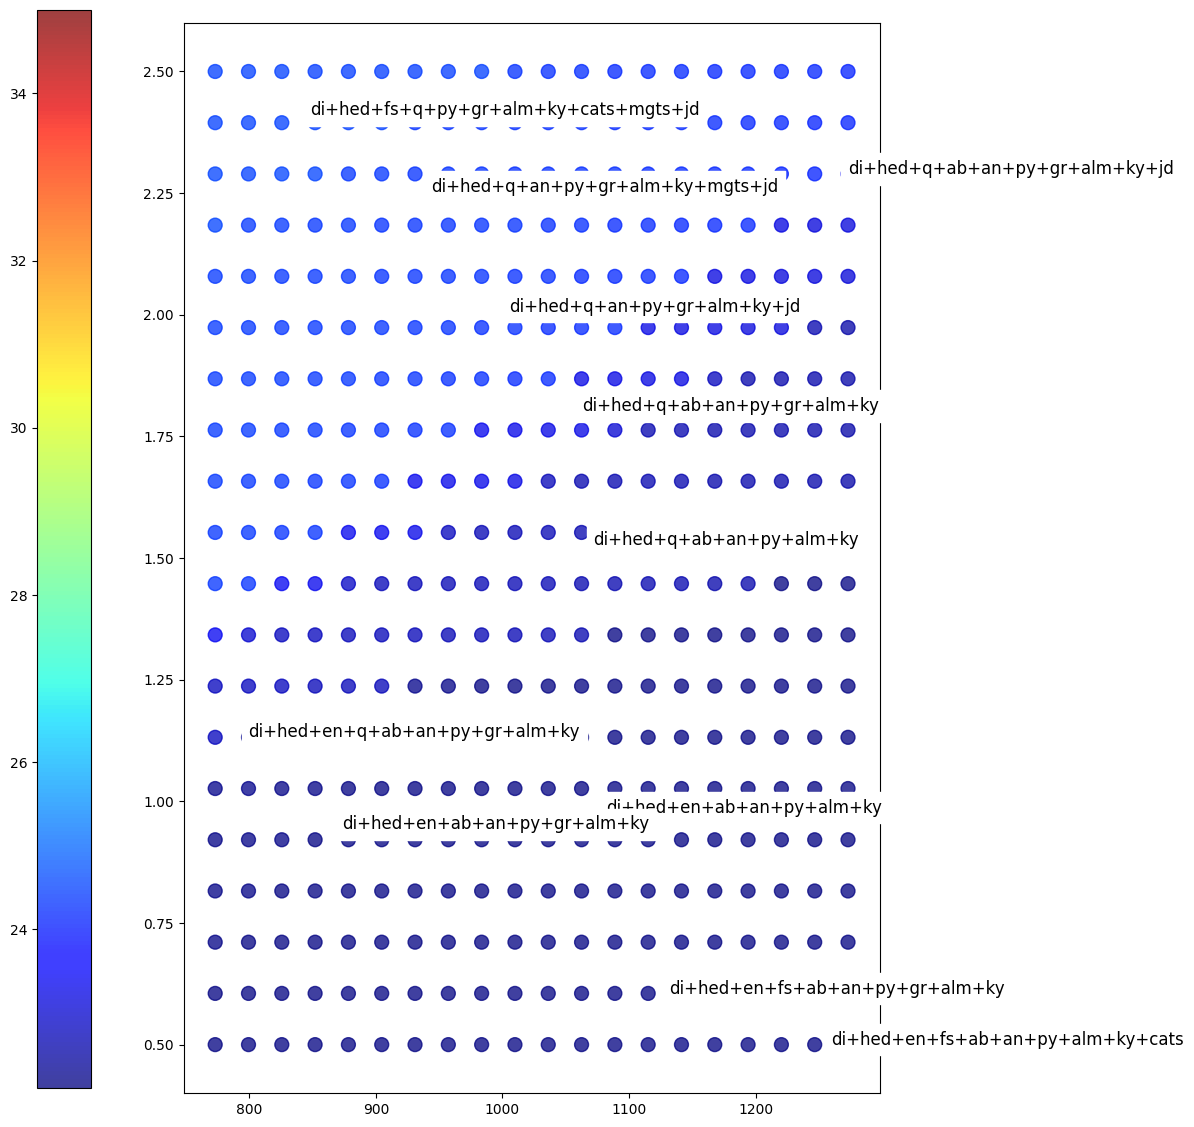

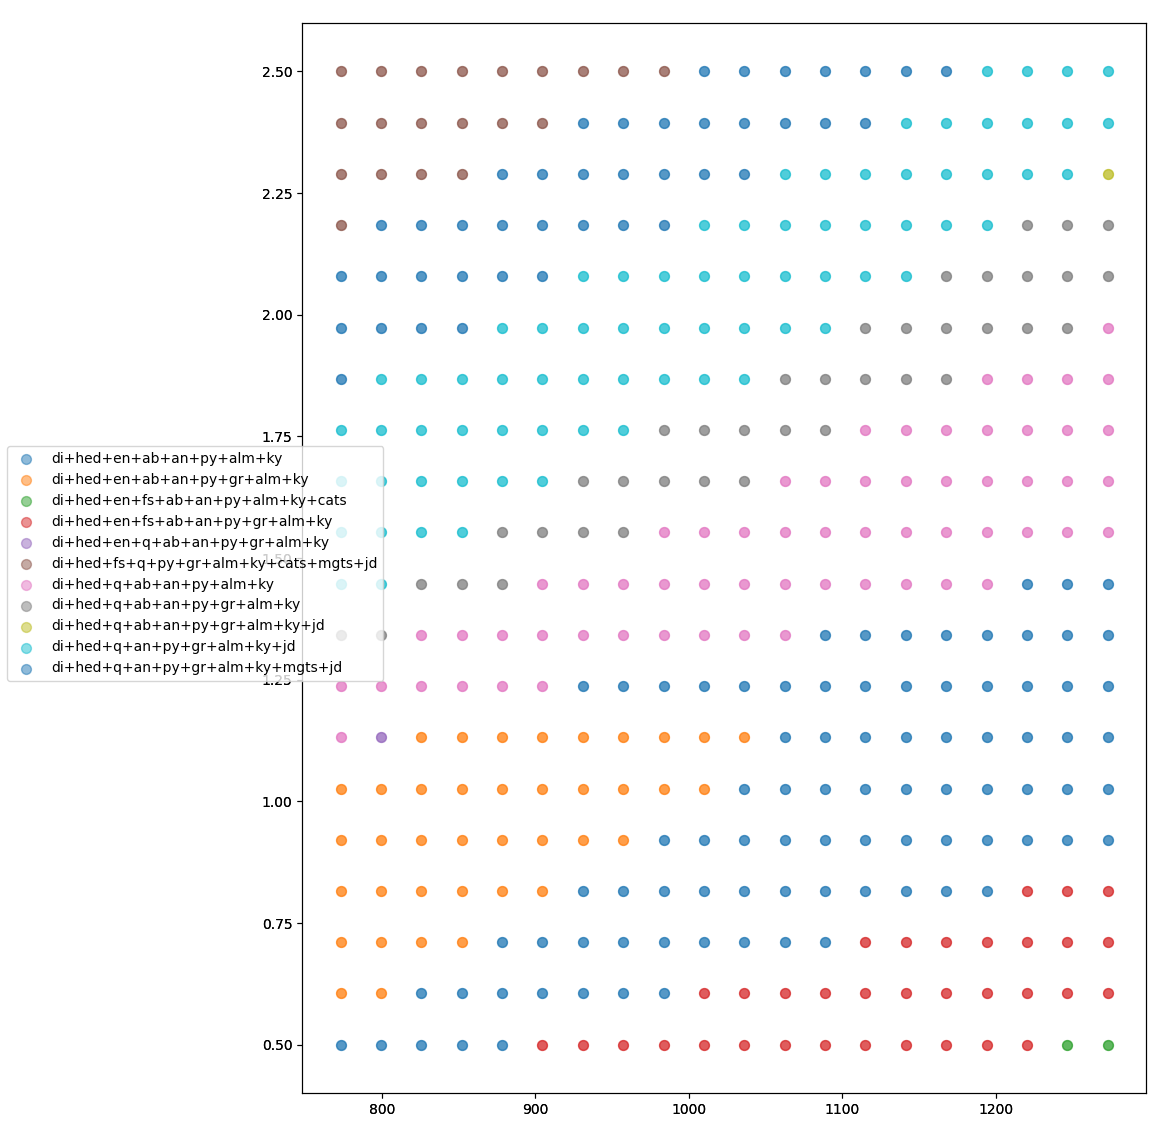

In [5]:
Tmin = 773
Tmax = 1273
nT = 20

Pmin = 0.5
Pmax = 2.5
nP = 20

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)
phases = ['di', 'hed', 'en', 'fs', 'q', 'an', 'py', 'gr', "alm", 'ky']
mi0 = np.asarray([
    0.1,  # di
    0.1,  # hed
    0.1,  # en
    0.1,  # fs
    0.1,  # q
    0.1,  # an
    0.1,  # py
    0.1,  # gr
    0.1,  # alm
    0.1,  # ky
    0.1, # cats
    0.1, #mgts
    0.1, #ab
    0.1,
])

# initial compositions of phases in terms of EMs
Cik0 = np.asarray([            
    1.,  # di
    1.,
    1.,  # en
    1.,  # fs
    1.,  # q
    1.,  # an
    1.,  # py
    1.,  # gr
    1.,  # alm
    1.,  # ky
    1.,
    1.,
    1.,
    1.
])

run_reaction(
    "ec_simple_hgp_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=T,
    p_range=P,
    t0=1200,
    p0=2.0,
    reload=False,
    save=True,
)

(array(['Clinopyroxene_slb_ph', 'Quartz_slb_ph', 'Garnet_slb_ph',
        'Kyanite_slb_ph'], dtype='<U20'),
 array(['cpx', 'qtz', 'gt', 'ky'], dtype='<U3'))

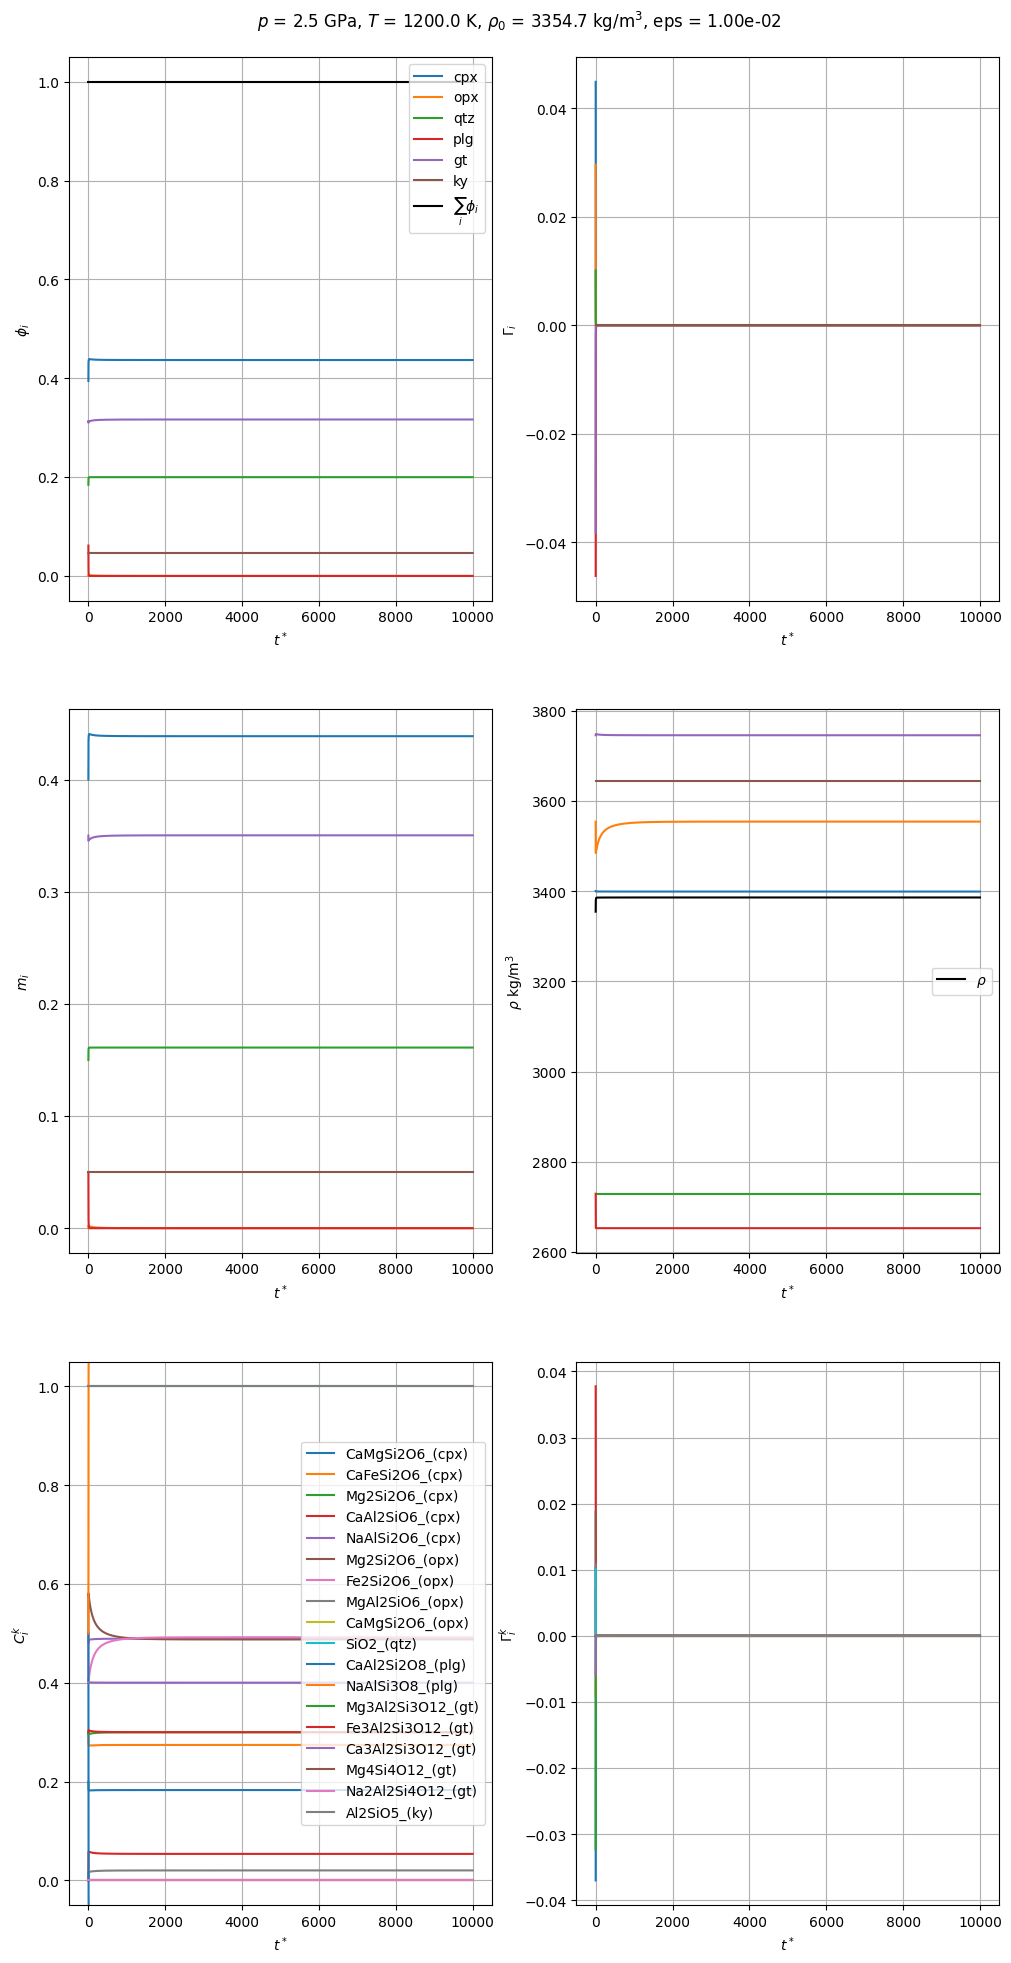

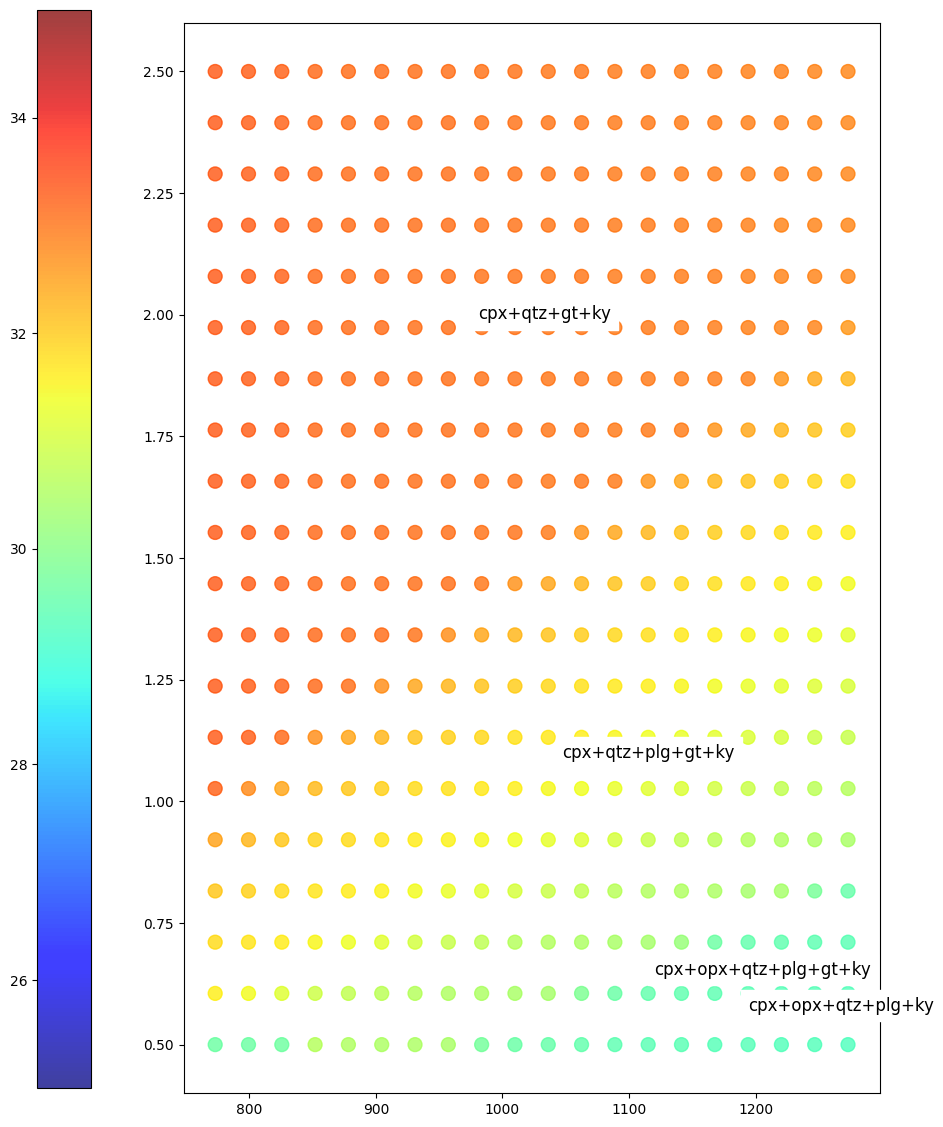

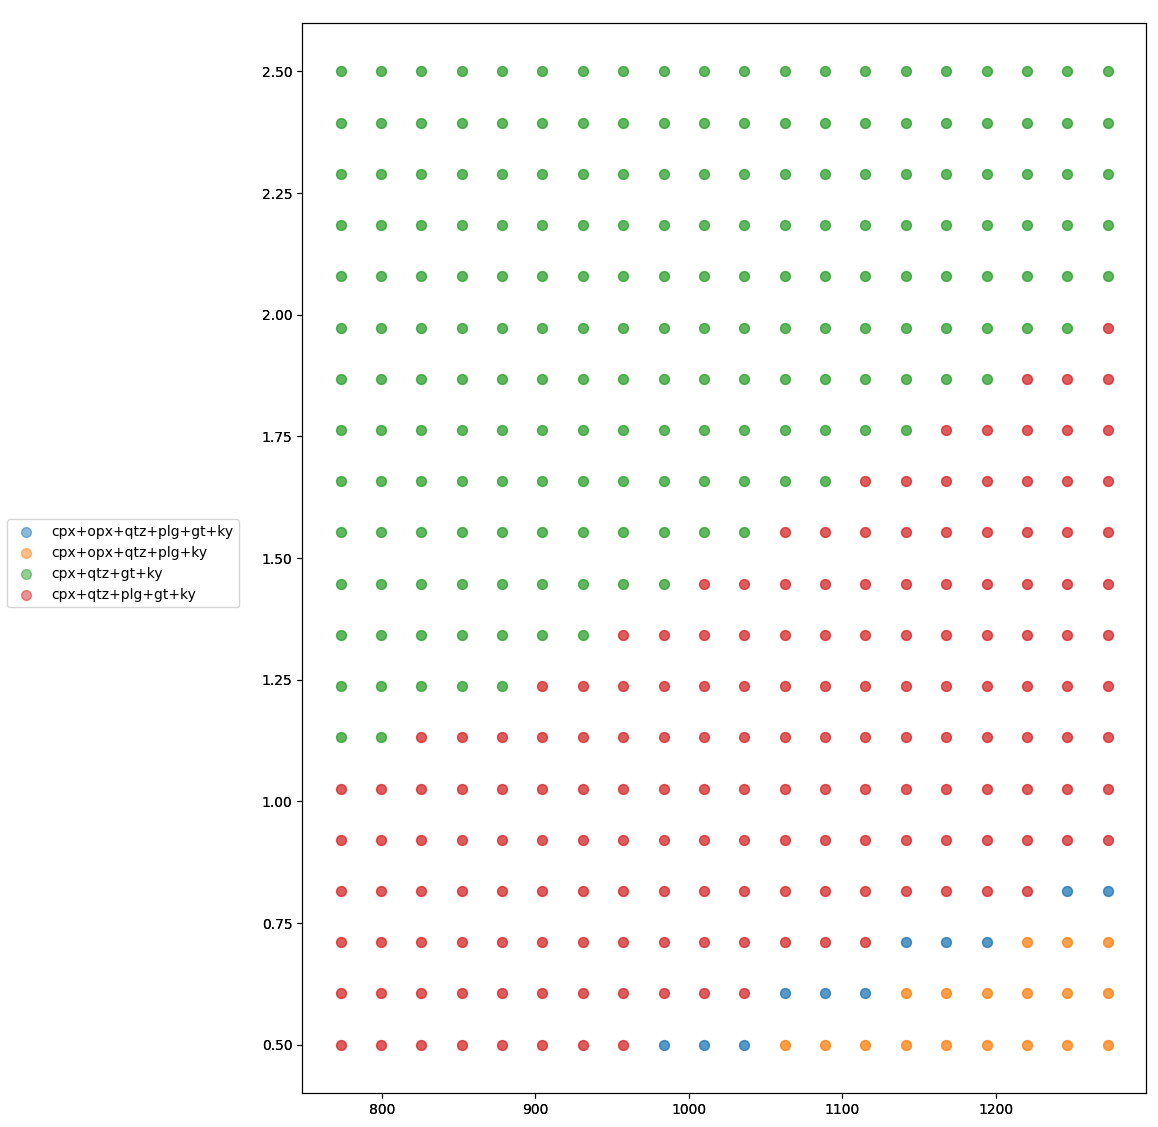

In [11]:
# Simple eclogite w/ Stixrude

Tmin = 773
Tmax = 1273
nT = 20

Pmin = 0.5
Pmax = 2.5
nP = 20

T = np.linspace(Tmin,Tmax,nT)
P = np.linspace(Pmin,Pmax,nP)

phases = [
    'Clinopyroxene',#'di', 'hed', 'jd','cats'
    'Orthopyroxene',#'en', 'fs', 
    'Quartz',#'q', 
    'Feldspar',#'ab','an',
    'Garnet',#'py', 'gr', "alm", 
    'Kyanite'
]

# Simple eclogite w/ Stixrude
ems = [
    'Diopside', 'Hedenbergite', 'Clinoenstatite', 'CaTschermaks', 'Jadeite',
    'Enstatite', 'Ferrosilite', 'MgTschermaks', 'OrthoDiopside',
    'Quartz',
    'Anorthite','Albite',
    'Pyrope', 'Almandine', 'Grossular', 'MgMajorite', 'NaMajorite',
    'Kyanite'
]

mi0 = np.asarray([
    0.4,
    0.0,
    0.15,
    0.05,
    0.35,
    0.05
])

Cik0 = np.asarray([
    0.2, 0.3, 0., 0., 0.5,
    0.5, 0.5, 0., 0.,
    1.,
    0.5, 0.5,
    0.3, 0.3, 0.4, 0., 0.,
    1.,
])

run_reaction(
    "ec_simple_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=T,
    p_range=P,
    t0=1200,
    p0=2.5,
    reload=False,
    save=True,
)